In [1]:
import numpy as np
import pandas as pd
from cylib.apis.all_api import *
from cylib.qmtdata.cyxtdata import xtdata
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# 以HS300为例

### 注意事项

> - 财报中有一些值是累计值，比如说公司的营业收入，每季度财报统计的是从财报年初期到本期累计的值，而不是单季度的营业收入。
> 
> - 在计算某些初期的值时，不一定是选择财报年的第一个季度(3月)，而是考虑公司实际公布的财报的季度，防止因为没有3月份的数据而错误地计算。
>
> - 解决市值中的日期缺失问题
>
> - 解决大量使用iloc的低效率问题
>
> - 对TTM求同比增长率时，不能使用fillna对null进行0值填充，因为TTM的null是值无效值
>
> - 股票代码和日期统一由小到大排序
>
> - pandas的1.4版本之后，Dataframe不再有append函数，因此`All_data.append(temp)`会报错，要使用：`pd.concat([All_data, temp], ignore_index=True)`

> 获取单日期的数据时，要注意一下事项：
>
> - 如果当天有数据，则返回一个三个列表的Dataframe(trade_date, ts_code, factor_name)，如果没有数据，则返回None
>
> - 如果是需要用之前数据进行计算的(比如：同比增长、环比增长等)，则需要将此范围日期内的数据加入计算。
> - **获取的是在当日发布的财报数据❗❗**

In [2]:
hs300_list = list(xtdata.get_index_weight("000300.SH").keys())
xtdata.download_financial_data(hs300_list, table_list=["Balance", "Income", "CashFlow", "PershareIndex", "Top10holder", "Holdernum", "Capital"]) # 下载数据
financial_data = xtdata.get_financial_data(hs300_list, ["Balance", "Income", "CashFlow", "PershareIndex", "Top10holder", "Holdernum", "Capital"])

In [4]:
# trade_date = '20150101' #每天的日期
# common_param = {}  #共有自定义参数

# def DIY_FACTOR1_SCRIPT(trade_date, common_param):
#     NEW_DATA_DF = calc_factor()
#     # 你的因子增量计算代码
#     return NEW_DATA_DF # 返回一个df给数据库，有三列，分别是：trade_date、ts_code、factor_name

# fact_dict = {"FACTOR1": DIY_FACTOR1_SCRIPT,
#             "FACTOR2": DIY_FACTOR2_SCRIPT,
#             ......}

In [6]:
def MV_DF(Stock_list, Start_date, End_date):
    """
    获取某一段时间的总市值数据。
    
    由于后面市值的因子可能需要获取季度最后一天的数据，
    而在季度最后一天有可能不是交易日而导致没有数据，
    此时采用最近一天交易日的数据作为替代。
        
    注：
    1. 某个股票因为停牌而没有数据，采用最近一天交易日的数据作为替代
    2. 处理完成之后，值依旧为Null，说明这个股票在这个日期还没有上市，没有数据
    3. 目前晨乐数据库中的数据最早的日期为2014.01.02
    4. 原始市值数据的单位是万元，为了转换为元，要乘以10000
    5. 由于上市公司会不定期变动股本数量(不一定是每季度的最后一天变动)，
       而变动股本数量的日期可能不是交易日，因此我们还需要加入上市公司变动
       股本数量的日期Changed_dates。如果为了提高效率，不加也可以。
    """
    def Quarter_End_Dates(start_date, end_date):
        # 获取每个季度最后的一天
        start = pd.to_datetime(start_date)
        end = pd.to_datetime(end_date)
        quarter_end_dates = (
            pd.date_range(start=start, end=end, freq="Q")
            .to_period("Q")
            .to_timestamp("D")
            + pd.offsets.QuarterEnd()
        )
        return quarter_end_dates
    def Get_Capital_Changeable_Dates(Stock_list, Begin_date, End_date):
        """
        获取上市公司股本变化的日期
        """
        Financial_DF = xtdata.get_financial_data(Stock_list, ["Capital"])
        All_data = pd.DataFrame()
        for asset in Financial_DF.keys():
            temp = Financial_DF[asset]["Capital"][
                [
                    "m_timetag", 
                    "m_anntime"]
            ]
            temp = temp[(temp.m_timetag >= Begin_date) & (temp.m_timetag <= End_date)]
            All_data = pd.concat([All_data, temp], ignore_index=True)

        All_data["Year"] = All_data["m_timetag"].apply(lambda x: x[:4]).astype(int)
        All_data["Month"] = All_data["m_timetag"].apply(lambda x: x[4:6]).astype(int)
        All_data["m_timetag"] = pd.to_datetime(All_data["m_timetag"])
        All_data["m_anntime"] = pd.to_datetime(All_data["m_anntime"])
        All_data.reset_index(drop=True, inplace=True)
        All_data.set_index("m_timetag", inplace=True)
        return All_data.index.unique()
    Changable_dates = Get_Capital_Changeable_Dates(Stock_list, Start_date, End_date)

    # Today_Date = datetime.today().strftime("%Y%m%d")  # 今天的日期
    MV = get_price(
        ts_code_list=Stock_list,
        feature_list=["total_mv"], # 总市值
        start_date=Start_date,
        trade_date=End_date,
        target_type="stock",
    )
    MV = MV.reset_index()
    MV_pivot = MV.pivot(index="trade_date", columns="ts_code", values="total_mv")
    Quarter_Dates = Quarter_End_Dates(Start_date, End_date)
    
    # 将交易日日期与季度最后一天日期合并，并排序
    Combined_date = pd.Index(sorted(set(MV_pivot.index) | set(Quarter_Dates) | set(Changable_dates)))
    
    # 创建一个新的Dataframe，与原来的市值Dataframe保持相同的日期和股票名称
    all_combinations = pd.MultiIndex.from_product(
        [Combined_date, Stock_list], 
        names=["trade_date", "ts_code"]
    )
    all_combinations_df = pd.DataFrame(index=all_combinations).reset_index()
    
    # 将新的Dataframe与市值Dataframe合并，采用左连接的方法
    price_whole = pd.merge(
        all_combinations_df, MV, 
        on=["trade_date", "ts_code"], 
        how="left"
    )
    
    # 为了方便缺失的数据显示出来，这里使用pivot，并采用前值填充的方法
    Combined_DF = price_whole.pivot(index="trade_date", columns="ts_code", values="total_mv")
    Combined_DF = Combined_DF.ffill()
    
    # 再将pivot转换成常用的形式，方便后续处理
    Combined_DF = Combined_DF.reset_index().melt(
        id_vars="trade_date", 
        var_name="ts_code", 
        value_name="total_mv"
    )
    Combined_DF["total_mv"] = Combined_DF["total_mv"] * 10000
    Combined_DF = Combined_DF.sort_values(["trade_date", "ts_code"]).reset_index(drop=True)
    return Combined_DF
# Market_Value_DF = MV_DF(hs300_list, "20140101", "20240816")
# Market_Value_DF

,trade_date,ts_code,total_mv
0,2014-01-02,000001.SZ,1.002540e+11
1,2014-01-02,000002.SZ,8.799970e+10
2,2014-01-02,000063.SZ,4.743810e+10
3,2014-01-02,000100.SZ,1.972270e+10
4,2014-01-02,000157.SZ,4.153510e+10
...,...,...,...
839395,2024-08-16,688303.SH,4.287730e+10
839396,2024-08-16,688363.SH,2.937270e+10
839397,2024-08-16,688396.SH,4.816280e+10
839398,2024-08-16,688599.SH,3.726710e+10


### 账面杠杆(7.21)

(Market Leverage)

$$
账面杠杆=\frac{最近报告期总资产}{最近同期股东权益总计}
$$

表示资产总额是股东权益总额的多少倍，作者测试结果表明平均回报率与账面杠杆负相关；Barra中的账面杠杆=最近报告期的(非流动负债合计+优先股账面价值+普通股账面价值)/最近报告期的普通股账面价值

In [7]:
Market_Leverage = {
    "中文名称": "账面杠杆",
    "英文名称": "market leverage",
    "表达式": "最近报告期总资产/最近同期股东权益合计",
    "说明": "表示资产总额是股东权益总额的多少倍，作者测试结果表明平均回报率与账面杠杆负相关；Barra中的账面杠杆=最近报告期的(非流动负债合计+优先股账面价值+普通股账面价值)/最近报告期的普通股账面价值",
}

# Market leverage
def Market_Leverage(Stock_list, Date):
    Financial_DF = xtdata.get_financial_data(Stock_list, ["Balance"])
    # Market leverage
    All_data = pd.DataFrame()
    for asset in Financial_DF.keys():
        temp = Financial_DF[asset]["Balance"][
            [
                "m_timetag", 
                "m_anntime", 
                "total_equity", 
                "tot_liab_shrhldr_eqy"
            ]
        ]
        temp["ts_code"] = asset
        temp = temp[
            [
                "ts_code",
                "m_timetag",
                "m_anntime",
                "total_equity",
                "tot_liab_shrhldr_eqy"
            ]
        ]
        temp = temp[temp.m_anntime == Date]
        All_data = pd.concat([All_data, temp], ignore_index=True)
    if All_data.empty: return None

    All_data["Year"] = All_data["m_timetag"].apply(lambda x: x[:4]).astype(int)
    All_data["Month"] = All_data["m_timetag"].apply(lambda x: x[4:6]).astype(int)
    All_data["m_timetag"] = pd.to_datetime(All_data["m_timetag"])
    All_data["m_anntime"] = pd.to_datetime(All_data["m_anntime"])
    # All_data = All_data[All_data.m_timetag == Date]

    All_data["Market_Leverage"] = All_data["tot_liab_shrhldr_eqy"] / All_data["total_equity"]
    All_data["Market_Leverage"] = All_data["Market_Leverage"].replace([np.inf, -np.inf], np.nan)
    All_data = All_data[["m_timetag", "ts_code", "Market_Leverage"]]
    All_data = All_data.rename(columns={"m_timetag": "trade_date"})
    All_data.reset_index(drop=True, inplace=True)
    return All_data

ML = Market_Leverage(hs300_list, "20240814")
ML

,trade_date,ts_code,Market_Leverage
0,2024-06-30,000895.SZ,1.729464
1,2024-06-30,002938.SZ,1.366662
2,2024-06-30,300999.SZ,2.206753
3,2024-06-30,601138.SH,2.108256


### 单季度成本费用利润率同比增长率(7.13)

(YoY of CIR)

$$
\frac{最近报告期单季度成本费用利润率 - 上年同期单季度成本费用利润率}{abs(上年同期单季度成本费用利润率)}
$$
① 成长因子是基于股票过去一段时间的各项估值或盈利指标计算得到的增长量或增长率指标，用于衡量公司各个维度的成长性;

② 计算成长因子时，最常用的统计维度有:环比增长率(或环比增量)、同比增长率(或同比增量)，计算用的基础财务数据也有“最近12个月TTM”和“单季度”2类，经测试发现:“单季度同比”和“TTM环比”这2个维度下计算得到的因子表现通常相对更优;

③ 至于增长率和增量，表现相差不大，增长率更具可比性，增量更不容易受基础指标取值异常的影响。
成本费用利用率（Cost-to-Income Ratio，简称CIR）是一个用来衡量公司或者机构在运营过程中，为每单位营收所消耗的成本和费用的比率指标。它通常用于评估一个企业的运营效率和财务健康状况。

---

- 营业成本是指企业销售商品或提供劳务的成本。营业成本又分为主营业务成本和其他业务成本。他们是与主营业务收入和其他业务收入相对应的一组概念。
- 营业总成本是指企业在经营活动中所有的成本支出，包括营业成本、营业税金及附加、销售费用、管理费用、财务费用和资产减值损失。

- 成本费用利润率(CIR)
$$ \text{CIR} = \frac{\text{Operating Costs and Expenses}}{\text{Operating Income}} \times 100\% $$

其中，

- **Operating Costs and Expenses** 表示企业在运营过程中产生的所有成本和费用，包括但不限于人力成本、设备折旧、租金、利息支出等。
  
- **Operating Income** 是企业在正常运营活动中所获得的收入，通常指营业收入减去营业成本。

成本费用利用率的数值越低，说明企业在获取每单位收入时的成本和费用相对较低，运营效率较高。高成本费用利用率则可能表明企业的成本控制能力较弱，运营效率不佳。

在金融行业，成本费用利用率也被用作评估银行和金融机构的核心指标之一，以衡量其运营效率和盈利能力的关键指标之一。

> 注：考虑到有一些公司在某些季度的数据有缺失，在遍历上年同期的数据时，使用loc进行索引，这会导致遍历的速度变慢，但可以避免出现计算错误。
>
> 注意是单季度的值，要对原始值做差分

In [8]:
def Prev_Quarter_end(date):
    """
    获取上一个季度的末尾日期，如果日期是当前季度的末尾日期，则直接返回该日期。
    """
    date = pd.to_datetime(date)
    Quarter_end = pd.Timestamp(date).to_period('Q').end_time.normalize()
    # 检查输入日期是否是当前季度的末尾日期
    if date == Quarter_end:
        return Quarter_end.to_pydatetime()
    else:
        # 计算上一个季度的末尾日期
        prev_quarter_end = Quarter_end - pd.offsets.QuarterEnd(1)
        return prev_quarter_end.normalize().to_pydatetime()

In [10]:
# YoY of CIR
def CIR_YoY(Stock_list, End_date):
    Prev_Quarter_date = Prev_Quarter_end(End_date)
    Begin_date = (Prev_Quarter_date - pd.DateOffset(years=1)).strftime("%Y%m%d")
    print(f"Begin date: {Begin_date}, End date: {End_date}")
    Financial_DF = xtdata.get_financial_data(Stock_list, ["Income"])
    All_data = pd.DataFrame()
    for asset in Financial_DF.keys():
        temp = Financial_DF[asset]["Income"][
            [
                "m_timetag", 
                "m_anntime", 
                "revenue", 
                "total_operating_cost"]
        ]
        temp["ts_code"] = asset
        temp = temp[
            [
                "ts_code", 
                "m_timetag", 
                "m_anntime", 
                "revenue", 
                "total_operating_cost"]
        ]
        temp = temp[(temp.m_timetag >= Begin_date) & (temp.m_timetag <= End_date)]
        All_data = pd.concat([All_data, temp], ignore_index=True)

    All_data["Year"] = All_data["m_timetag"].apply(lambda x: x[:4]).astype(int)
    All_data["Month"] = All_data["m_timetag"].apply(lambda x: x[4:6]).astype(int)
    All_data["m_timetag"] = pd.to_datetime(All_data["m_timetag"])
    All_data["m_anntime"] = pd.to_datetime(All_data["m_anntime"])

    def cal_group_dif(Group, Factor):
        def cal_diff(group, factor):
            res = group[factor].diff()
            res = res.fillna(group[factor]) # Fill NaN values with original values
            return res
        Group[f"{Factor}_diff"] = (
            Group.groupby("Year")
            .apply(lambda x: cal_diff(x, Factor))
            .reset_index(level=0, drop=True)
        )
        return Group
    All_data = (
        All_data.groupby("ts_code")
        .apply(lambda x: cal_group_dif(x, "revenue"))
        .reset_index(drop=True)
    )
    All_data = (
        All_data.groupby("ts_code")
        .apply(lambda x: cal_group_dif(x, "total_operating_cost"))
        .reset_index(drop=True)
    )

    All_data["CIR"] = All_data["total_operating_cost_diff"] / All_data["revenue_diff"]
    All_data["CIR"] = All_data["CIR"].replace([np.inf, -np.inf], np.nan)

    def Cal_Factor_YoY(Group, Factor):
        """
        计算同比增长。
        YoY = (本期值 - 上期值) / abs(上期值)
        如果上一期值和本期值为0，则增长率为0；
        如果上一期值为0，本期不为0，则增长率为NaN；
        其他情况正常计算。
        """
        DF = Group[Factor].fillna(0)
        DF_Shift = Group[Factor].fillna(0).shift(1)
        DIFF = DF - DF_Shift
        Group["CIR_Ratio"] = np.where(DIFF == 0, 0, DIFF / abs(DF_Shift))
        Group["CIR_Ratio"] = Group["CIR_Ratio"].replace([np.inf, -np.inf], np.nan)
        return Group
    All_data = All_data.groupby(["ts_code", "Month"]).apply(lambda x: Cal_Factor_YoY(x, "CIR")).reset_index(drop=True)
    All_data = All_data[All_data.m_anntime == End_date]
    if All_data.empty: return None
    All_data = All_data.sort_values(by=['ts_code', 'm_timetag'])
    All_data = All_data[["m_timetag", "ts_code", "CIR_Ratio"]]
    All_data = All_data.rename(columns={"m_timetag": "trade_date"})
    All_data.reset_index(drop=True, inplace=True)
    return All_data
CY = CIR_YoY(hs300_list, "20240814")
CY

Begin date: 20230630, End date: 20240814


,trade_date,ts_code,CIR_Ratio
0,2024-06-30,000895.SZ,0.017393
1,2024-06-30,002938.SZ,0.037020
2,2024-06-30,300999.SZ,0.003211
3,2024-06-30,601138.SH,0.006730


In [81]:
# DDF = xtdata.get_financial_data(hs300_list, ["Income"])
# All_data = pd.DataFrame()
# for asset in DDF.keys():
#     temp = DDF[asset]["Income"][
#         [
#             "m_timetag", 
#             "m_anntime"]
#     ]
#     temp["ts_code"] = asset
#     temp = temp[
#         [
#             "ts_code", 
#             "m_timetag", 
#             "m_anntime"]
#     ]
#     All_data = pd.concat([All_data, temp], ignore_index=True)
# All_data

,ts_code,m_timetag,m_anntime
0,000001.SZ,19911231,19920430
1,000001.SZ,19921231,19930226
2,000001.SZ,19930630,19930805
3,000001.SZ,19931231,19940329
4,000001.SZ,19940630,19940630
...,...,...,...
19297,688981.SH,20230331,20230512
19298,688981.SH,20230630,20230826
19299,688981.SH,20230930,20231110
19300,688981.SH,20231231,20240329


### 线性纯化利润率(7.5)

(Linear Purified Net Profit)

财务数据中的信息可以分为对未来股价有预测能力的信息(信号)与对未来股价没有预测能力的信息(噪声)。数据的信比越大，其作为因子的预测能力就越强。净利润数据中有不少其它财务数据决定的部分就属于噪音项，找出它们对于净利润数据的贡献后，将其剔除，可以提升纯化后净利润数据的预测能力。

$$
NetProfit_i = a_i + \beta_{1, i}NonOperatingIncome_i + \beta_{2, i}CashPaidEmployees + \epsilon_i
$$
$$
i \in \{0, 1, 2, ..., N-1\},\ N=8 \  (default)
$$

以当天最近N个季度的净利润$NetProfit$作为Y、以对应季度的营业外收入$NonOperatingIncome$和支付给职工以及为职工支付的现金数据$CashPaidEmployees$作为X，进行OLS线性回归，回归前需对X和Y进行Z-Score标准化处理；回归得到的最近一个季度上的残差$\epsilon_i$即为LPNP在当天的因子值。

> 要对原始数据进行差分运算

##### 这种计算方法的实用性

1. **信号与噪音的分离**：
   - 通过将净利润中受其他财务数据（如营业外收入和支付给员工的现金）影响的部分剔除，可以去掉噪音。这样的分离能够更清晰地理解影响净利润的基本因素。

2. **增强预测能力**：
   - 通过净利润数据的纯化，可能提升其对未来股价的预测能力。数据越干净（即越能反映真实的经营表现，去掉噪音），作为预测因子的效果就越好。

3. **关注核心运营**：
   - 这种方法强调核心运营现金流和业绩指标，这些通常对投资者更为相关，而外部因素或一次性事件可能不那么重要。这种关注能够提供公司运营效率的更准确的表现。

4. **定量分析**：
   - 使用定量的方法来处理财务数据，可以在不同公司或不同时间段中保持一致性。这种标准化有助于进行比较和评估。

##### 为什么使用OLS进行模型拟合

1. **简单易懂**：
   - 普通最小二乘法（OLS）回归实施和解释都非常简单。它为预测变量提供了明确的系数，显示每个变量对因变量（净利润）的影响程度。

2. **最佳线性无偏估计量**：
   - 在某些假设下（例如线性性、同方差性、无多重共线性），OLS提供最佳线性无偏估计量（BLUE），这意味着OLS回归将产生方差最低的线性估计。

3. **金融领域的常见做法**：
   - OLS回归是金融领域常用的建模方法，具有较强的普遍性，使得结果更易于与其他利益相关者交流。

4. **建模残差**：
   - 通过关注残差（拟合模型后的剩余部分），可以捕捉到“纯化”后的净利润，去除所选预测因素的影响。这一残差能够揭示净利润中未解释的变异部分，表明其余部分可能与未建模的因素有关。

5. **假设的适用性**：
   - OLS回归的假设通常与财务数据的特征较为匹配，使其成为分析的自然选择。

通过OLS回归的线性净利润纯化方法有效地去除了净利润数据中的噪音，使得对未来股价预测的深入见解和准确性得以提升。该方法基于稳健的统计原则，旨在明确公司的财务健康状况。

`Ordinary Least Squares (OLS)` regression is a statistical technique used to estimate the relationship between one or more independent variables (predictor variables) and a dependent variable. In OLS regression, the goal is to find the best-fitting line that minimizes the sum of the squared differences between the observed values and the values predicted by the model.

Here's how OLS regression works:

1. **Model Specification**: OLS regression assumes a linear relationship between the independent variables (X) and the dependent variable (y). The general form of a simple linear regression model is y = β0 + β1*X + ε, where β0 is the intercept, β1 is the slope coefficient, X is the independent variable, y is the dependent variable, and ε is the error term.

2. **Estimation**: OLS regression estimates the coefficients (β0 and β1) that minimize the sum of the squared residuals (errors) between the observed values of the dependent variable and the values predicted by the model.

3. **Goodness of Fit**: OLS regression also provides information on the goodness of fit of the model through measures like R-squared, which indicates the proportion of variance explained by the independent variables.

4. **Inference**: OLS regression allows for statistical inference, such as hypothesis testing on the coefficients to determine if they are significantly different from zero.

In the provided code snippet, OLS regression is performed using the `sm.OLS` function from the `statsmodels.api` module. The `fit` method is called on the model to estimate the coefficients and perform the regression. The resulting coefficients are then used to calculate the LPNP factor value based on the latest quarter data.

By using OLS regression, you can analyze the relationship between variables, make predictions based on the model, and assess the significance of the relationships between variables.

In [30]:
def OSL_Regression(NetProfit, NonOperIncome, CashPaidEmployees, N):
    if len(NetProfit) != N or len(NonOperIncome) != N or len(CashPaidEmployees) != N:
        return None
    # Combine the input series into a DataFrame
    df = pd.DataFrame(
        {
            "NetProfit": NetProfit,
            "NonOperIncome": NonOperIncome,
            "CashPaidEmployees": CashPaidEmployees,
        }
    )
    # print(NetProfit)
    # print(NonOperIncome)
    # print(CashPaidEmployees)
    # Z-Score standardization
    df_standardized = ((df - df.mean()) / df.std()).fillna(0)

    # Prepare the data for regression
    X = sm.add_constant(df_standardized[["NonOperIncome", "CashPaidEmployees"]])
    y = df_standardized["NetProfit"]

    # Perform OLS regression
    model = sm.OLS(y, X).fit()

    # print(model.rsquared)
    # rsqure_list.append(model.rsquared)

    # Get the coefficients
    a = model.params["const"]
    beta1 = model.params["NonOperIncome"]
    beta2 = model.params["CashPaidEmployees"]

    # Calculate LPNP factor value
    latest_data = df_standardized.iloc[-1]  # Get the latest quarter data
    LPNP = (
        latest_data["NetProfit"]
        - a
        - beta1 * latest_data["NonOperIncome"]
        - beta2 * latest_data["CashPaidEmployees"]
    )
    # print("LPNP Factor Value:", LPNP)
    return LPNP

def Linear_Purified_NP(Stock_list, End_date, N=8):
    Prev_Quarter_date = Prev_Quarter_end(End_date)
    Begin_date = (Prev_Quarter_date - pd.DateOffset(months=3*N)).strftime("%Y%m%d")
    # Begin_date = "20140101"
    print(f"Begin date: {Begin_date}, End date: {End_date}")
    # 由于资产负债表和现金流表中的m_anntime不同，因此去掉
    Financial_DF = xtdata.get_financial_data(Stock_list, ["Income", "CashFlow"])
    Income = pd.DataFrame()
    CashFlow = pd.DataFrame()
    for asset in Financial_DF.keys():
        temp_income = Financial_DF[asset]["Income"][
            [
                "m_timetag", 
                "m_anntime", 
                "net_profit_incl_min_int_inc", 
                "plus_non_oper_rev"]
        ]
        temp_cashflow = Financial_DF[asset]["CashFlow"][
            [
                "m_timetag", 
                "m_anntime", 
                "cash_pay_beh_empl"]
        ]
        temp_income["ts_code"] = asset
        temp_cashflow["ts_code"] = asset
        temp_income = temp_income[
            [
                "ts_code", 
                "m_timetag", 
                "m_anntime", 
                "net_profit_incl_min_int_inc", 
                "plus_non_oper_rev"]
        ]
        temp_cashflow = temp_cashflow[
            [
                "ts_code", 
                "m_timetag", 
                "m_anntime", 
                "cash_pay_beh_empl"]]
        temp_income = temp_income[
            (temp_income.m_timetag >= Begin_date) 
            & (temp_income.m_timetag <= End_date)
        ]
        temp_cashflow = temp_cashflow[
            (temp_cashflow.m_timetag >= Begin_date)
            & (temp_cashflow.m_timetag <= End_date)
        ]
        Income = pd.concat([Income, temp_income], ignore_index=True)
        CashFlow = pd.concat([CashFlow, temp_cashflow], ignore_index=True)

    keys = ["ts_code", "m_timetag"]
    All_data = pd.merge(Income, CashFlow, on=keys, how="left")
    All_data["Year"] = All_data["m_timetag"].apply(lambda x: x[:4]).astype(int)
    All_data["Month"] = All_data["m_timetag"].apply(lambda x: x[4:6]).astype(int)
    All_data["m_timetag"] = pd.to_datetime(All_data["m_timetag"])
    All_data["m_anntime_x"] = pd.to_datetime(All_data["m_anntime_x"]) # Income's column
    All_data["m_anntime_y"] = pd.to_datetime(All_data["m_anntime_y"]) # CashFlow's column
    # 由于Income和Cashflow表中的披露时间m_anntime不一样
    # 取同一个财报中，在这两个表中最早的日期作为实际的财报披露时间
    All_data['m_anntime'] = All_data[['m_anntime_x', 'm_anntime_y']].min(axis=1)
    All_data.fillna(0, inplace=True)

    def cal_group_dif(Group, Factor):
        def cal_diff(group, factor):
            res = group[factor].diff()
            res = res.fillna(group[factor])  # Fill NaN values with original values
            return res

        Group[f"{Factor}_diff"] = (
            Group.groupby("Year")
            .apply(lambda x: cal_diff(x, Factor))
            .reset_index(level=0, drop=True)
        )
        return Group

    All_data = All_data.groupby("ts_code").apply(
        lambda x: cal_group_dif(x, "net_profit_incl_min_int_inc")
    ).reset_index(drop=True)
    All_data = All_data.groupby("ts_code").apply(
        lambda x: cal_group_dif(x, "plus_non_oper_rev")
    ).reset_index(drop=True)
    All_data = All_data.groupby("ts_code").apply(
        lambda x: cal_group_dif(x, "cash_pay_beh_empl")
    ).reset_index(drop=True)

    def cal_factor_LPNP(group, factor_NP, factor_NOI, factor_CPE, N):
        NP_Rolling = group[factor_NP].rolling(N)
        NOI_Rolling = group[factor_NOI].rolling(N)
        CPE_Rolling = group[factor_CPE].rolling(N)
        group["LPNP"] = [
            OSL_Regression(a, b, c, N)
            for a, b, c in zip(NP_Rolling, NOI_Rolling, CPE_Rolling)
        ]
        return group

    All_data = All_data.groupby("ts_code").apply(
        lambda x: cal_factor_LPNP(
            x,
            "net_profit_incl_min_int_inc_diff",
            "plus_non_oper_rev_diff",
            "cash_pay_beh_empl_diff",
            N,
        )
    ).reset_index(drop=True)
    All_data = All_data[All_data.m_anntime == End_date]
    if All_data.empty: return None
    All_data = All_data[["m_timetag", "ts_code", "LPNP"]]
    All_data = All_data.rename(columns={"m_timetag": "trade_date"})
    All_data.reset_index(drop=True, inplace=True)
    return All_data

LPNP = Linear_Purified_NP(hs300_list, "20240814")
LPNP

Begin date: 20220630, End date: 20240814


,trade_date,ts_code,LPNP
0,2024-06-30,000895.SZ,-1.015849
1,2024-06-30,002938.SZ,-1.157628
2,2024-06-30,300999.SZ,-0.958343
3,2024-06-30,601138.SH,-0.193937


### 供应链地位因子(7.3)

测试结果表明；客户集中度因子与供应商集中度因子均为反向因子，表明市场相对较为认可上下游分散度较高公司；占资水平和获现率为正向因子；合成的供应链地位因子有较强的选股能力。https://max.book118.com/html/2018/1213/7052042053001164.shtm

$$ 
客户集中度 = \frac{前五大客户年度销售额}{公司年度销售总}
$$
$$
供应商集中度= \frac{前五大供应商年度采购额}{公司年度采购总额}
$$
$$
占资水平= \frac{应付账款+预收账款-应收账款-预付账款-存货}{营业收入}
$$
$$
客户集中度 = \frac{经营活动中产生的现金净流量}{净利润+折旧摊销+财务费用}
$$

### 户均持股比例(6.30)

(Average sharehold ratio)

为股东的平均持股数占总股本的比例，一般来说，比例大的股票筹码集中度高，筹码锁定性强，浮筹少，上涨较容易。
$$
\frac{总股本/股东户数}{总股本} = \frac{1}{股东户数}
$$

> 注意事项
>
> - 持股数据的日期不一定是季度末
>
> - 有一些公司没有披露股东数据，因此显示为0，计算出的户均持股比例为Null

In [14]:
# Average sharehold ratio
def Average_Sharehold_Ratio(Stock_list, Date):
    Financial_DF = xtdata.get_financial_data(Stock_list, ["Holdernum"])
    """
    Attention: In Holdernum table, data names are different
    endDate = m_timetag
    declareDate = m_anntime
    """
    All_data = pd.DataFrame()
    for asset in Financial_DF.keys():
        temp = Financial_DF[asset]["Holdernum"][
            ["endDate", "declareDate", "shareholder"]]
        temp["ts_code"] = asset
        temp = temp[
            [
                "ts_code",
                "endDate",
                "declareDate",
                "shareholder"
            ]
        ]
        temp = temp[temp.declareDate == Date]
        All_data = All_data = pd.concat([All_data, temp], ignore_index=True)

    All_data["Year"] = All_data["endDate"].apply(lambda x: x[:4]).astype(int)
    All_data["Month"] = All_data["endDate"].apply(lambda x: x[4:6]).astype(int)
    All_data["endDate"] = pd.to_datetime(All_data["endDate"])
    All_data["declareDate"] = pd.to_datetime(All_data["declareDate"])
    All_data.drop_duplicates(subset=["ts_code", "endDate", "declareDate"], inplace=True)
    
    All_data['Average_Sharehold_Ratio'] = (1 / All_data['shareholder']).replace([np.inf, -np.inf], np.nan)
    All_data = All_data[["endDate", "ts_code", "Average_Sharehold_Ratio"]]
    All_data = All_data.rename(columns={"endDate": "trade_date"})
    All_data.reset_index(drop=True, inplace=True)
    return All_data
ASR = Average_Sharehold_Ratio(hs300_list, "20240814")
ASR

,trade_date,ts_code,Average_Sharehold_Ratio
0,2024-08-09,000408.SZ,0.000028
1,2024-08-09,000876.SZ,0.000005
2,2024-08-10,000895.SZ,0.000005
3,2024-07-31,002460.SZ,NaN
4,2024-06-30,002938.SZ,0.000017
5,2024-06-30,601138.SH,0.000005


### 单季度净利润同比增长率(6.26)

(YoY of Net Profit)

$$
\frac{最近报告期的单季度净利率-上年同期的单季度净利率}{abs(上年同期的单季度净利率)}
$$

> 要对原始数据进行差分运算

In [18]:
# YoY of NP
def Net_Profit_YoY(Stock_list, End_date):
    Prev_Quarter_date = Prev_Quarter_end(End_date)
    # 由于要计算差分，开始的日期是第一季度末的日期
    Begin_date = (Prev_Quarter_date - pd.DateOffset(years=1, month=3)).strftime("%Y%m%d")
    print(f"Begin date: {Begin_date}, End date: {End_date}")
    Financial_DF = xtdata.get_financial_data(Stock_list, ["Income"])
    All_data = pd.DataFrame()
    for asset in Financial_DF.keys():
        temp = Financial_DF[asset]["Income"][
            [
                "m_timetag", 
                "m_anntime", 
                "net_profit_incl_min_int_inc"]
        ]
        temp["ts_code"] = asset
        temp = temp[
            [
                "ts_code", 
                "m_timetag", 
                "m_anntime", 
                "net_profit_incl_min_int_inc"]
        ]
        temp = temp[(temp.m_timetag >= Begin_date) & (temp.m_timetag <= End_date)]
        All_data = pd.concat([All_data, temp], ignore_index=True)

    All_data["Year"] = All_data["m_timetag"].apply(lambda x: x[:4]).astype(int)
    All_data["Month"] = All_data["m_timetag"].apply(lambda x: x[4:6]).astype(int)
    All_data["m_timetag"] = pd.to_datetime(All_data["m_timetag"])
    All_data["m_anntime"] = pd.to_datetime(All_data["m_anntime"])

    def cal_group_dif(Group, Factor):
        def cal_diff(group, factor):
            res = group[factor].diff()
            res = res.fillna(group[factor]) # Fill NaN values with original values
            return res
        Group[f"{Factor}_diff"] = (
            Group.groupby("Year")
            .apply(lambda x: cal_diff(x, Factor))
            .reset_index(level=0, drop=True)
        )
        return Group
    All_data = (
        All_data.groupby("ts_code")
        .apply(lambda x: cal_group_dif(x, "net_profit_incl_min_int_inc"))
        .reset_index(drop=True)
    )
    
    def Cal_Factor_YoY(Group, Factor):
        """
        计算同比增长。
        YoY = (本期值 - 上期值) / abs(上期值)
        如果上一期值和本期值为0，则增长率为0；
        如果上一期值为0，本期不为0，则增长率为NaN；
        其他情况正常计算。
        """
        DF = Group[Factor]
        DF_Shift = Group[Factor].shift(1)
        DIFF = DF - DF_Shift
        Group["Net_Profit_YoY"] = np.where(DIFF == 0, 0, DIFF / abs(DF_Shift))
        Group["Net_Profit_YoY"] = Group["Net_Profit_YoY"].replace([np.inf, -np.inf], np.nan)
        return Group
    All_data = All_data.groupby(["ts_code", "Month"]).apply(lambda x: Cal_Factor_YoY(x, "net_profit_incl_min_int_inc_diff")).reset_index(drop=True)
    All_data = All_data.sort_values(by=['ts_code', 'm_timetag'])
    All_data = All_data[All_data.m_anntime == End_date]
    if All_data.empty: return None
    All_data = All_data[["m_timetag", "ts_code", "Net_Profit_YoY"]]
    All_data = All_data.rename(columns={"m_timetag": "trade_date"})
    All_data.reset_index(drop=True, inplace=True)
    return All_data
YoY_NP = Net_Profit_YoY(hs300_list, "20240814")
YoY_NP

Begin date: 20230330, End date: 20240814


,trade_date,ts_code,Net_Profit_YoY
0,2024-06-30,000895.SZ,-0.240179
1,2024-06-30,002938.SZ,-0.270345
2,2024-06-30,300999.SZ,0.921047
3,2024-06-30,601138.SH,0.129333


### 流动性经营资产变动(6.16)

(Changes in liquid operating asset)

流动性经营资产中的分项在会计核算时带有较大的主观性，其中的应收款项、存货等都容易涉及盈余操纵，可靠性较低；流动性经营资产的变动与企业未来盈利负相关，与股票未来收益也负相关，容易造成错误定价。

$$
\frac{最近报告期的流动性经营资产-上年同期值}{平均总资产}
$$
其中流动性经营资产 = 流动资产中剔除金融资产相关科目后的剩余部分 

≈ 应收账款 + 应收票据 + 预付款项 + 其他应收款 + 存货 + 待摊费用

平均总资产 = $\frac{期初总资产+期未总资产}{2} $

> Q: 期末总资产如何确定？是否是指最近报告期的总资产？
> 
> 暂时确定初期资产为1季度报的资产

In [22]:
# Changes in liquid operating asset
def CLOA(Stock_list, End_date):
    Prev_Quarter_date = Prev_Quarter_end(End_date)
    Begin_date = (Prev_Quarter_date - pd.DateOffset(years=1)).strftime("%Y%m%d")
    print(f"Begin date: {Begin_date}, End date: {End_date}")
    Financial_DF = xtdata.get_financial_data(Stock_list, ["Balance"])
    All_data = pd.DataFrame()
    Liquid_Asset_Names = [
        "account_receivable",
        "bill_receivable",
        "advance_payment",
        "other_receivable",
        "inventories",
        "apportioned_cost",
    ]
    Total_Asset_Name = ["tot_liab_shrhldr_eqy"]
    for asset in Financial_DF.keys():
        temp = Financial_DF[asset]["Balance"][
            ["m_timetag", "m_anntime"] 
            + Liquid_Asset_Names 
            + Total_Asset_Name
        ]
        temp["ts_code"] = asset
        temp = temp[
            ["ts_code", "m_timetag", "m_anntime"]
            + Liquid_Asset_Names
            + Total_Asset_Name
        ]
        temp = temp[(temp.m_timetag >= Begin_date) & (temp.m_timetag <= End_date)]
        All_data = pd.concat([All_data, temp], ignore_index=True)

    All_data["Year"] = All_data["m_timetag"].apply(lambda x: x[:4]).astype(int)
    All_data["Month"] = All_data["m_timetag"].apply(lambda x: x[4:6]).astype(int)
    All_data["m_timetag"] = pd.to_datetime(All_data["m_timetag"])
    All_data["m_anntime"] = pd.to_datetime(All_data["m_anntime"])
    All_data.fillna(0, inplace=True)
    All_data["liquid_asset"] = (
        All_data["account_receivable"]
        + All_data["bill_receivable"]
        + All_data["advance_payment"]
        + All_data["other_receivable"]
        + All_data["inventories"]
        + All_data["apportioned_cost"]
    )

    def Cal_Average(Group, Factor):
        Asset = Group[Factor]
        First_Asset = Asset.iloc[0]
        Group["Average_Total_Asset"] = (Asset + First_Asset) / 2
        return Group

    All_data = All_data.groupby(["ts_code", "Year"]).apply(
        lambda x: Cal_Average(x, "tot_liab_shrhldr_eqy")).reset_index(drop=True)
    All_data = All_data[All_data.m_anntime == End_date]
    if All_data.empty: return None
    All_data = All_data.sort_values(by=['ts_code', 'm_timetag'])
    All_data["CLOA"] = All_data["liquid_asset"] / All_data["Average_Total_Asset"]
    All_data["CLOA"] = All_data["CLOA"].replace([np.inf, -np.inf], np.nan)
    All_data = All_data[["m_timetag", "ts_code", "CLOA"]]
    All_data = All_data.rename(columns={"m_timetag": "trade_date"})
    All_data.reset_index(drop=True, inplace=True)
    return All_data

CLOA_DF = CLOA(hs300_list, "20240814")
CLOA_DF

Begin date: 20230630, End date: 20240814


,trade_date,ts_code,CLOA
0,2024-06-30,000895.SZ,0.195806
1,2024-06-30,002938.SZ,0.201539
2,2024-06-30,300999.SZ,0.275769
3,2024-06-30,601138.SH,0.656016


### 企业年龄(6.6)

(IPO Age)

上市时间久的公司比上市时间短的公司能获得更高的投资收益。

$$ 
当前时刻与公司IPO日之间的月份数量
$$

> 与其他因子的输出格式一致，包含: ts_code, m_timetag, m_anntime, factor_value

In [24]:
def IPO_Age(Stock_list, Date):
    Stock_info = get_targets_info(target_type='stock')
    IPO_Age_DF = Stock_info[Stock_info['ts_code'].isin(Stock_list)][['ts_code', 'list_date']]
    IPO_Age_DF['list_date'] = pd.to_datetime(IPO_Age_DF['list_date'])
    IPO_Age_DF['date'] = pd.to_datetime(Date)
    def Cal_Factor_IPO_Age(row):
        list_date = row['list_date']
        now_date = row['date']
        month_difference = (now_date.year - list_date.year) * 12 + now_date.month - list_date.month
        if month_difference < 0: return 0
        return month_difference
    IPO_Age_DF['IPO_Age'] = IPO_Age_DF.apply(Cal_Factor_IPO_Age, axis=1)
    IPO_Age_DF = IPO_Age_DF[["date", "ts_code", "IPO_Age"]]
    IPO_Age_DF = IPO_Age_DF.rename(columns={"date": "trade_date"})
    IPO_Age_DF.reset_index(drop=True, inplace=True)
    return IPO_Age_DF
IPO_AGE = IPO_Age(hs300_list, "20240814")
IPO_AGE

,trade_date,ts_code,IPO_Age
0,2024-08-14,000001.SZ,400
1,2024-08-14,000002.SZ,403
2,2024-08-14,000063.SZ,321
3,2024-08-14,000100.SZ,247
4,2024-08-14,000157.SZ,286
...,...,...,...
295,2024-08-14,688303.SH,37
296,2024-08-14,688363.SH,57
297,2024-08-14,688396.SH,54
298,2024-08-14,688599.SH,50


### 负债市值比(6.5)

(Debt-to-market ratio)

反映公司建立资产的资金来源中股本与债务比例，是公司财务杠杆的衡量指标。

$$
\frac{最近报告期负债合计}{总市值}
$$

In [25]:
def Debt2Market_Ratio(Stock_list, Date):
    Financial_DF = xtdata.get_financial_data(Stock_list, ["Balance"])
    All_data = pd.DataFrame()
    for asset in Financial_DF.keys():
        temp = Financial_DF[asset]["Balance"][["m_timetag", "m_anntime", "tot_liab"]]
        temp["ts_code"] = asset
        temp = temp[["ts_code", "m_timetag", "m_anntime", "tot_liab"]]
        temp = temp[temp.m_anntime == Date]
        All_data = pd.concat([All_data, temp], ignore_index=True)

    if All_data.empty: return None
    All_data["Year"] = All_data["m_timetag"].apply(lambda x: x[:4]).astype(int)
    All_data["Month"] = All_data["m_timetag"].apply(lambda x: x[4:6]).astype(int)
    All_data["m_timetag"] = pd.to_datetime(All_data["m_timetag"])
    All_data["m_anntime"] = pd.to_datetime(All_data["m_anntime"])
    
    All_data = pd.merge(All_data, 
                        Market_Value_DF, 
                        how='left', 
                        left_on=['ts_code', 'm_timetag'], 
                        right_on=['ts_code', 'trade_date'])
    All_data["Debt2Market_Ratio"] = All_data["tot_liab"] / All_data["total_mv"]
    All_data["Debt2Market_Ratio"] = All_data["Debt2Market_Ratio"].replace([np.inf, -np.inf], np.nan)
    All_data = All_data[["trade_date", "ts_code", "Debt2Market_Ratio"]]
    All_data.reset_index(drop=True, inplace=True)
    return All_data

D2M_DF = Debt2Market_Ratio(hs300_list, "20240814")
D2M_DF

,trade_date,ts_code,Debt2Market_Ratio
0,2024-06-30,000895.SZ,0.185498
1,2024-06-30,002938.SZ,0.116253
2,2024-06-30,300999.SZ,0.785657
3,2024-06-30,601138.SH,0.283228


### 金融负债变动(5.21)

(Change in Financial Liability)

金融负债主要包含一些计息债务，会计核算时简洁明确，可靠性高，盈余操纵空间很小；金融负债的变动与企业未来盈利正相关，与股票未来收益也正相关。

$$
\frac{最近报告期的金融负债-上年同期值}{平均总资产}
$$

金融负债 = 短期借款 + 交易性金融负债 + 应付票据 + 一年内到期的非流动负债 + 长期借款 + 应付债券

平均总资产 = $ \frac{初期初总资产 + 期未总资产}{2} $

In [26]:
def CFL(Stock_list, End_date):
    Prev_Quarter_date = Prev_Quarter_end(End_date)
    Begin_date = (Prev_Quarter_date - pd.DateOffset(years=1)).strftime("%Y%m%d")
    print(f"Begin date: {Begin_date}, End date: {End_date}")
    Financial_DF = xtdata.get_financial_data(Stock_list, ["Balance"])
    All_data = pd.DataFrame()
    Financial_Asset_Names = [
        "shortterm_loan",
        "tradable_fin_assets",
        "notes_payable",
        "non_current_liability_in_one_year",
        "long_term_loans",
        "bonds_payable",
    ]
    Total_Asset_Name = ["tot_liab_shrhldr_eqy"]
    for asset in Financial_DF.keys():
        temp = Financial_DF[asset]["Balance"][
            ["m_timetag", "m_anntime"]
            + Financial_Asset_Names 
            + Total_Asset_Name
        ]
        temp["ts_code"] = asset
        temp = temp[
            ["ts_code", "m_timetag", "m_anntime"]
            + Financial_Asset_Names
            + Total_Asset_Name
        ]
        temp = temp[(temp.m_timetag >= Begin_date) & (temp.m_timetag <= End_date)]
        All_data = pd.concat([All_data, temp], ignore_index=True)

    All_data["Year"] = All_data["m_timetag"].apply(lambda x: x[:4]).astype(int)
    All_data["Month"] = All_data["m_timetag"].apply(lambda x: x[4:6]).astype(int)
    All_data["m_timetag"] = pd.to_datetime(All_data["m_timetag"])
    All_data["m_anntime"] = pd.to_datetime(All_data["m_anntime"])
    All_data.fillna(0, inplace=True)
    All_data["Financial_Liability"] = (
        All_data["shortterm_loan"]
        + All_data["tradable_fin_assets"]
        + All_data["notes_payable"]
        + All_data["non_current_liability_in_one_year"]
        + All_data["long_term_loans"]
        + All_data["bonds_payable"]
    )

    def Cal_Factor_Diff(Group, Factor):
        """
        计算同比差值。
        Diff = 本期值 - 上期值
        如果运算中出现了null值，则结果为null值
        """
        DF = Group[Factor]
        DF_Shift = Group[Factor].shift(1)
        Group[f"{Factor}_Diff"] = DF - DF_Shift
        return Group

    All_data = All_data.groupby(["ts_code", "Month"]).apply(
        lambda x: Cal_Factor_Diff(x, "Financial_Liability")
    ).reset_index(drop=True)
    All_data = All_data.sort_values(by=["ts_code", "m_timetag"])

    def Cal_Average(Group, Factor):
        Asset = Group[Factor]
        First_Asset = Asset.iloc[0]
        Group["Average_Total_Asset"] = (Asset + First_Asset) / 2
        return Group

    All_data = All_data.groupby(["ts_code", "Year"]).apply(
        lambda x: Cal_Average(x, "tot_liab_shrhldr_eqy")).reset_index(drop=True)
    All_data = All_data[All_data.m_anntime == End_date]
    if All_data.empty: return None
    All_data = All_data.sort_values(by=['ts_code', 'm_timetag'])
    All_data["CFL"] = All_data["Financial_Liability_Diff"] / All_data["Average_Total_Asset"]
    All_data["CFL"] = All_data["CFL"].replace([np.inf, -np.inf], np.nan)
    All_data = All_data[["m_timetag", "ts_code", "CFL"]]
    All_data = All_data.rename(columns={"m_timetag": "trade_date"})
    All_data.reset_index(drop=True, inplace=True)
    return All_data
CFL_DF = CFL(hs300_list, "20240814")
CFL_DF

Begin date: 20230630, End date: 20240814


,trade_date,ts_code,CFL
0,2024-06-30,000895.SZ,0.056895
1,2024-06-30,002938.SZ,-0.000102
2,2024-06-30,300999.SZ,-0.113865
3,2024-06-30,601138.SH,-0.054339


### 现金比率(5.19)

(Cash Ratio)

现金比率反映企业的即刻变现能力，或是企业立即偿还到期债务的能力
$$
\frac{最近报告期货币资金+最近报告期交易性金融资产}{最近同期流动负债合计}
$$

In [27]:
# Cash Ratio
def Cash_Ratio(Stock_list, Date):
    Financial_DF = xtdata.get_financial_data(Stock_list, ["Balance"])
    All_data = pd.DataFrame()
    for asset in Financial_DF.keys():
        temp = Financial_DF[asset]["Balance"][
            [
                "m_timetag", 
                "m_anntime", 
                "cash_equivalents", 
                "tradable_fin_assets", 
                "total_current_liability"
            ]
        ]
        temp["ts_code"] = asset
        temp = temp[
            [
                "ts_code",
                "m_timetag",
                "m_anntime",
                "cash_equivalents", 
                "tradable_fin_assets", 
                "total_current_liability"
            ]
        ]
        temp = temp[temp.m_anntime == Date]
        All_data = pd.concat([All_data, temp], ignore_index=True)

    if All_data.empty: return None
    All_data["Year"] = All_data["m_timetag"].apply(lambda x: x[:4]).astype(int)
    All_data["Month"] = All_data["m_timetag"].apply(lambda x: x[4:6]).astype(int)
    All_data["m_timetag"] = pd.to_datetime(All_data["m_timetag"])
    All_data["m_anntime"] = pd.to_datetime(All_data["m_anntime"])
    All_data.fillna(0, inplace=True)

    All_data["Cash_Ratio"] = (
        (
            All_data["cash_equivalents"] 
            + All_data["tradable_fin_assets"]
        )
        / All_data["total_current_liability"]
    )
    All_data["Cash_Ratio"] = All_data["Cash_Ratio"].replace([np.inf, -np.inf], np.nan)
    All_data = All_data[["m_timetag", "ts_code", "Cash_Ratio"]]
    All_data = All_data.rename(columns={"m_timetag": "trade_date"})
    All_data.reset_index(drop=True, inplace=True)
    return All_data

CR = Cash_Ratio(hs300_list, "20240814")
CR

,trade_date,ts_code,Cash_Ratio
0,2024-06-30,000895.SZ,0.424111
1,2024-06-30,002938.SZ,1.047269
2,2024-06-30,300999.SZ,0.585849
3,2024-06-30,601138.SH,0.469529


### 毛利率增长减销售收入增长(5.15)

(Gross Profit growth Difference in sales revenue growth)

$$
最近单季度毛利润的同比增速-同期单季度营业收入的同比增速
$$

> 要对原始数据进行差分运算

In [28]:
# Gross margin growth Difference in sales revenue growth
def GPG_Minus_SRG(Stock_list, End_date):
    Prev_Quarter_date = Prev_Quarter_end(End_date)
    # 由于要计算差分，开始的日期是第一季度末的日期
    Begin_date = (Prev_Quarter_date - pd.DateOffset(years=1, month=3)).strftime("%Y%m%d")
    print(f"Begin date: {Begin_date}, End date: {End_date}")
    Financial_DF = xtdata.get_financial_data(Stock_list, ["Income"])
    All_data = pd.DataFrame()
    for asset in Financial_DF.keys():
        temp = Financial_DF[asset]["Income"][
            [
                "m_timetag", 
                "m_anntime", 
                "revenue", 
                "total_expense",
                "revenue_inc"
            ]
        ]
        temp["ts_code"] = asset
        temp = temp[
            [
                "ts_code",
                "m_timetag",
                "m_anntime",
                "revenue", 
                "total_expense",
                "revenue_inc"
            ]
        ]
        temp = temp[(temp.m_timetag >= Begin_date) & (temp.m_timetag <= End_date)]
        All_data = pd.concat([All_data, temp], ignore_index=True)

    All_data["Year"] = All_data["m_timetag"].apply(lambda x: x[:4]).astype(int)
    All_data["Month"] = All_data["m_timetag"].apply(lambda x: x[4:6]).astype(int)
    All_data["m_timetag"] = pd.to_datetime(All_data["m_timetag"])
    All_data["m_anntime"] = pd.to_datetime(All_data["m_anntime"])
    
    # Gross Profit
    All_data['Gross_Profit'] = All_data['revenue'].fillna(0) - All_data['total_expense'].fillna(0)
    
    def cal_group_dif(Group, Factor):
        def cal_diff(group, factor):
            res = group[factor].diff()
            res = res.fillna(group[factor]) # Fill NaN values with original values
            return res
        Group[f"{Factor}_diff"] = (
            Group.groupby("Year")
            .apply(lambda x: cal_diff(x, Factor))
            .reset_index(level=0, drop=True)
        )
        return Group
    # 单季度毛利润
    All_data = (
        All_data.groupby("ts_code")
        .apply(lambda x: cal_group_dif(x, "Gross_Profit"))
        .reset_index(drop=True)
    )
    # 单季度营业收入
    All_data = (
        All_data.groupby("ts_code")
        .apply(lambda x: cal_group_dif(x, "revenue_inc"))
        .reset_index(drop=True)
    )

    def Cal_Factor_YoY(Group, Factor):
        """
        计算同比增长。
        YoY = (本期值 - 上期值) / abs(上期值)
        如果上一期值和本期值为0，则增长率为0；
        如果上一期值为0，本期不为0，则增长率为NaN；
        其他情况正常计算。
        """
        DF = Group[Factor].fillna(0)
        DF_Shift = Group[Factor].fillna(0).shift(1)
        DIFF = DF - DF_Shift
        Group[f"{Factor}_YoY"] = np.where(DIFF == 0, 0, DIFF / abs(DF_Shift))
        Group[f"{Factor}_YoY"] = Group[f"{Factor}_YoY"].replace([np.inf, -np.inf], np.nan)
        return Group

    All_data = All_data.groupby(["ts_code", "Month"]).apply(lambda x: Cal_Factor_YoY(x, "Gross_Profit_diff")).reset_index(drop=True)
    All_data = All_data.sort_values(by=['ts_code', 'm_timetag'])
    All_data = All_data.groupby(["ts_code", "Month"]).apply(lambda x: Cal_Factor_YoY(x, "revenue_inc_diff")).reset_index(drop=True)
    All_data = All_data.sort_values(by=['ts_code', 'm_timetag'])
    All_data = All_data[All_data.m_anntime == End_date]
    if All_data.empty: return None
    All_data['GMG_Minus_SRG'] = All_data["Gross_Profit_diff_YoY"] - All_data["revenue_inc_diff_YoY"]
    All_data = All_data[["m_timetag", "ts_code", "GMG_Minus_SRG"]]
    All_data = All_data.rename(columns={"m_timetag": "trade_date"})
    All_data.reset_index(drop=True, inplace=True)
    return All_data
GMG_Minus_SRG_DF = GPG_Minus_SRG(hs300_list, "20240814")
GMG_Minus_SRG_DF

Begin date: 20230330, End date: 20240814


,trade_date,ts_code,GMG_Minus_SRG
0,2024-06-30,000895.SZ,-0.013654
1,2024-06-30,002938.SZ,0.065520
2,2024-06-30,300999.SZ,0.449483
3,2024-06-30,601138.SH,-0.203409


### 单季度毛利率同比增长率(5.7)

(Gross Profit Growth)

$$
\frac{最近报告期单季度毛利率-上年同期单季度毛利率}{abs(上年同期单季度毛利率)}
$$

> 要对原始数据进行差分运算

In [37]:
# Gross profit growth 
def GPG(Stock_list, End_date):
    Prev_Quarter_date = Prev_Quarter_end(End_date)
    # 由于要计算差分，开始的日期是第一季度末的日期
    Begin_date = (Prev_Quarter_date - pd.DateOffset(years=1, month=3)).strftime("%Y%m%d")
    Financial_DF = xtdata.get_financial_data(Stock_list, ["Income"])
    All_data = pd.DataFrame()
    for asset in Financial_DF.keys():
        temp = Financial_DF[asset]["Income"][
            [
                "m_timetag", 
                "m_anntime", 
                "revenue", 
                "total_expense"
            ]
        ]
        temp["ts_code"] = asset
        temp = temp[
            [
                "ts_code",
                "m_timetag",
                "m_anntime",
                "revenue", 
                "total_expense"
            ]
        ]
        temp = temp[(temp.m_timetag >= Begin_date) & (temp.m_timetag <= End_date)]
        All_data = pd.concat([All_data, temp], ignore_index=True)

    All_data["Year"] = All_data["m_timetag"].apply(lambda x: x[:4]).astype(int)
    All_data["Month"] = All_data["m_timetag"].apply(lambda x: x[4:6]).astype(int)
    All_data["m_timetag"] = pd.to_datetime(All_data["m_timetag"])
    All_data["m_anntime"] = pd.to_datetime(All_data["m_anntime"])
    
    # Gross Profit
    All_data['Gross_Profit'] = All_data['revenue'].fillna(0) - All_data['total_expense'].fillna(0)
    def cal_group_dif(Group, Factor):
        def cal_diff(group, factor):
            res = group[factor].diff()
            res = res.fillna(group[factor]) # Fill NaN values with original values
            return res
        Group[f"{Factor}_diff"] = (
            Group.groupby("Year")
            .apply(lambda x: cal_diff(x, Factor))
            .reset_index(level=0, drop=True)
        )
        return Group
    # 单季度毛利润
    All_data = (
        All_data.groupby("ts_code")
        .apply(lambda x: cal_group_dif(x, "Gross_Profit"))
    ).reset_index(drop=True)

    def Cal_Factor_YoY(Group, Factor):
        """
        计算同比增长。
        YoY = (本期值 - 上期值) / abs(上期值)
        如果上一期值和本期值为0，则增长率为0；
        如果上一期值为0，本期不为0，则增长率为NaN；
        其他情况正常计算。
        """
        DF = Group[Factor].fillna(0)
        DF_Shift = Group[Factor].fillna(0).shift(1)
        DIFF = DF - DF_Shift
        Group["GPG_YoY"] = np.where(DIFF == 0, 0, DIFF / abs(DF_Shift))
        Group["GPG_YoY"] = Group["GPG_YoY"].replace([np.inf, -np.inf], np.nan)
        return Group

    All_data = All_data.groupby(["ts_code", "Month"]).apply(lambda x: Cal_Factor_YoY(x, "Gross_Profit_diff")).reset_index(drop=True)
    All_data = All_data.sort_values(by=['ts_code', 'm_timetag'])
    All_data = All_data[All_data.m_anntime == End_date]
    if All_data.empty: return None
    All_data = All_data[["m_timetag", "ts_code", "GPG_YoY"]]
    All_data = All_data.rename(columns={"m_timetag": "trade_date"})
    All_data.reset_index(drop=True, inplace=True)
    return All_data
GPG_DF = GPG(hs300_list, "20240814")
GPG_DF

,trade_date,ts_code,GPG_YoY
0,2024-06-30,000895.SZ,-0.110968
1,2024-06-30,002938.SZ,0.388270
2,2024-06-30,300999.SZ,0.354672
3,2024-06-30,601138.SH,0.257650


### 对数总市值(5.31)

(Logarithmic Market Value)

A股市值分布存在严重厚尾特征，取对数后，会使得因子分布更接近正态分布。

$$
In(当日收盘价\times 当日总股本)
$$

In [39]:
def Log_Market_Value(Stock_list, Date):
    MV = get_price(
        ts_code_list=Stock_list,
        feature_list=["total_mv"], # 总市值
        start_date=Date,
        trade_date=Date,
        target_type="stock",
    )
    MV = MV.reset_index()
    MV["total_mv"] = MV["total_mv"] * 10000
    MV["Log_Market_Value"] = np.log(MV["total_mv"])
    MV = MV[["trade_date", "ts_code", "Log_Market_Value"]]
    return MV

Log_Market_Value_DF = Log_Market_Value(hs300_list, "20240814")
Log_Market_Value_DF

,trade_date,ts_code,Log_Market_Value
0,2024-08-14,002007.SZ,24.079940
1,2024-08-14,000157.SZ,24.726191
2,2024-08-14,600018.SH,25.672749
3,2024-08-14,600570.SH,24.164786
4,2024-08-14,603259.SH,25.477709
...,...,...,...
295,2024-08-14,600039.SH,24.704513
296,2024-08-14,601100.SH,24.801647
297,2024-08-14,601818.SH,25.940086
298,2024-08-14,688303.SH,24.453709


### 销售收入增长存货增长(4.14)

(Revenue Growth Minus Inventory Growth)

$$
最近单季度营业收入的同比增速-同期单季度存货的同比增速
$$

> 要对原始数据进行差分运算

In [42]:
def RG_Minus_IG(Stock_list, End_date):
    Prev_Quarter_date = Prev_Quarter_end(End_date)
    # 由于要计算差分，开始的日期是第一季度末的日期
    Begin_date = (Prev_Quarter_date - pd.DateOffset(years=1, month=3)).strftime("%Y%m%d")
    print(f"Begin date: {Begin_date}, End date: {End_date}")
    Financial_DF = xtdata.get_financial_data(Stock_list, ["Balance", "Income"])
    Balance = pd.DataFrame()
    Income = pd.DataFrame()
    for asset in Financial_DF.keys():
        temp_balance = Financial_DF[asset]['Balance'][
            [
                "m_timetag", 
                "m_anntime",
                "inventories"]
        ]
        temp_income = Financial_DF[asset]["Income"][
            [
                "m_timetag", 
                "m_anntime",
                "revenue_inc"]
        ]
        temp_balance["ts_code"] = asset
        temp_income["ts_code"] = asset
        temp_balance = temp_balance[
            [
                "ts_code",
                "m_timetag", 
                "m_anntime",
                "inventories"]
        ]
        temp_income = temp_income[
            [
                "ts_code",
                "m_timetag", 
                "m_anntime",
                "revenue_inc"]
        ]
        temp_balance = temp_balance[(temp_balance.m_timetag >= Begin_date) & (temp_balance.m_timetag <= End_date)]
        temp_income = temp_income[(temp_income.m_timetag >= Begin_date) & (temp_income.m_timetag <= End_date)]
        Balance = pd.concat([Balance, temp_balance], ignore_index=True)
        Income = pd.concat([Income, temp_income], ignore_index=True)

    keys = ["ts_code", "m_timetag"]
    All_data = pd.merge(Balance, Income, on=keys, how='left')
    All_data["Year"] = All_data["m_timetag"].apply(lambda x: x[:4]).astype(int)
    All_data["Month"] = All_data["m_timetag"].apply(lambda x: x[4:6]).astype(int)
    All_data["m_timetag"] = pd.to_datetime(All_data["m_timetag"])
    All_data["m_anntime_x"] = pd.to_datetime(All_data["m_anntime_x"]) # Balance's column
    All_data["m_anntime_y"] = pd.to_datetime(All_data["m_anntime_y"]) # Income's column
    # Balance和Income表中的披露时间m_anntime可能不一样
    # 取同一个财报中，在这两个表中最早的日期作为实际的财报披露时间
    All_data['m_anntime'] = All_data[['m_anntime_x', 'm_anntime_y']].min(axis=1)
    
    def cal_group_dif(Group, Factor):
        def cal_diff(group, factor):
            res = group[factor].diff()
            res = res.fillna(group[factor]) # Fill NaN values with original values
            return res
        Group[f"{Factor}_diff"] = (
            Group.groupby("Year")
            .apply(lambda x: cal_diff(x, Factor))
            .reset_index(level=0, drop=True)
        )
        return Group
    # 单季度毛利润
    All_data = (
        All_data.groupby("ts_code")
        .apply(lambda x: cal_group_dif(x, "inventories"))
        .reset_index(drop=True)
    )
    All_data = (
        All_data.groupby("ts_code")
        .apply(lambda x: cal_group_dif(x, "revenue_inc"))
    ).reset_index(drop=True)
    
    def Cal_Factor_YoY(Group, Factor):
        DF = Group[Factor].fillna(0)
        DF_Shift = Group[Factor].fillna(0).shift(1)
        DIFF = DF - DF_Shift
        Group[f"{Factor}_YoY"] = np.where(DIFF == 0, 0, DIFF / abs(DF_Shift))
        Group[f"{Factor}_YoY"] = Group[f"{Factor}_YoY"].replace([np.inf, -np.inf], np.nan)
        return Group
    
    All_data = All_data.groupby(["ts_code", "Month"]).apply(lambda x: Cal_Factor_YoY(x, "inventories_diff")).reset_index(drop=True)
    All_data = All_data.sort_values(by=['ts_code', 'm_timetag'])
    All_data = All_data.groupby(["ts_code", "Month"]).apply(lambda x: Cal_Factor_YoY(x, "revenue_inc_diff")).reset_index(drop=True)
    All_data = All_data.sort_values(by=['ts_code', 'm_timetag'])
    All_data = All_data[All_data.m_anntime == End_date]
    if All_data.empty: return None
    All_data["RG_Minus_IG"] = All_data["revenue_inc_diff_YoY"] - All_data["inventories_diff_YoY"]
    All_data = All_data[["m_timetag", "ts_code", "RG_Minus_IG"]]
    All_data = All_data.rename(columns={"m_timetag": "trade_date"})
    All_data.reset_index(drop=True, inplace=True)
    return All_data
RG_Minus_IG_DF = RG_Minus_IG(hs300_list, "20240814")
RG_Minus_IG_DF

Begin date: 20230330, End date: 20240814


,trade_date,ts_code,RG_Minus_IG
0,2024-06-30,000895.SZ,0.926480
1,2024-06-30,002938.SZ,-12.536521
2,2024-06-30,300999.SZ,-2.590268
3,2024-06-30,601138.SH,-4.219269


### 有形资本回报率环比增长率(4.12)

(Tangible Assets Return QoQ)

$$
\frac{最近报告期有形资本回报率(TTM)-上一报告期有形资本回报率(TTM)}{abs(上一报告期有形资本回报率(TTM))}
$$

有形资本（Tangible Capital）通常是指企业在其运营中实际拥有的有形资产和资本。计算有形资本的方法可以简单地通过将有形资产减去有形负债来实现。具体计算公式如下：

有形资本 = 有形资产 - 有形负债

有形资产（Tangible Assets）包括公司拥有的物质资产，如土地、建筑物、设备、存货等。而有形负债（Tangible Liabilities）指的是与这些有形资产相关的负债，如与建筑物、设备等有形资产相关的负债。

有形资本回报率（Return on Tangible Capital）是一个衡量公司有效利用其有形资本（即实际拥有的有形资产和资本）来创造利润的指标。有形资本回报率可以帮助评估公司在资本投资方面的效率和盈利能力。

有形资本回报率的计算方法如下：

有形资本回报率 = 净利润 / 有形资本

其中：
- 净利润（Net Income）是公司在一定时间内的净利润，通常可以在财务报表中找到。
- 有形资本（Tangible Capital）是公司实际拥有的有形资产减去有形负债的值。

有形资本回报率的计算结果显示公司在每单位有形资本上创造的收益。较高的有形资本回报率表明公司更有效地利用其有形资本来实现利润。

(拓展)

**有形净资产回报率是衡量企业盈利能力的一个重要指标，它反映了企业在剔除无形资产后，能够用有形资产创造的利润。这个指标在财务分析中具有重要的参考价值，尤其在评估企业资产运营效率方面。**

有形净资产回报率（Tangible Net Asset Return on Investment，简称TNA ROI）是指企业净利润与有形净资产之间的比率。它体现了企业利用有形净资产创造利润的能力。计算公式为：

有形净资产回报率 = $\frac{净利润}{有形净资产}$

其中，有形净资产是指企业的总资产减去无形资产和其他递延费用后的净值。具体计算公式为：

有形净资产 = 总资产 - 无形资产 - 其他递延费用

In [45]:
def TAR_QoQ(Stock_list, End_date):
    Prev_Quarter_date = Prev_Quarter_end(End_date)
    Begin_date = (Prev_Quarter_date - pd.DateOffset(years=2)).strftime("%Y%m%d")
    print(f"Begin date: {Begin_date}, End date: {End_date}")
    Financial_DF = xtdata.get_financial_data(Stock_list, ["Balance", "Income"])
    Balance = pd.DataFrame()
    Income = pd.DataFrame()
    for asset in Financial_DF.keys():
        temp_balance = Financial_DF[asset]['Balance'][
            [
                "m_timetag", 
                "m_anntime",
                "intang_assets",
                "tot_liab_shrhldr_eqy"]
        ]
        temp_income = Financial_DF[asset]["Income"][
            [
                "m_timetag", 
                "m_anntime",
                "net_profit_incl_min_int_inc"]
        ]
        temp_balance["ts_code"] = asset
        temp_income["ts_code"] = asset
        temp_balance = temp_balance[
            [
                "ts_code",
                "m_timetag", 
                "m_anntime",
                "intang_assets",
                "tot_liab_shrhldr_eqy"]
        ]
        temp_income = temp_income[
            [
                "ts_code",
                "m_timetag", 
                "m_anntime",
                "net_profit_incl_min_int_inc"]
        ]
        temp_balance = temp_balance[(temp_balance.m_timetag >= Begin_date) & (temp_balance.m_timetag <= End_date)]
        temp_income = temp_income[(temp_income.m_timetag >= Begin_date) & (temp_income.m_timetag <= End_date)]
        Balance = pd.concat([Balance, temp_balance], ignore_index=True)
        Income = pd.concat([Income, temp_income], ignore_index=True)

    keys = ["ts_code", "m_timetag"]
    All_data = pd.merge(Balance, Income, on=keys, how='left')
    All_data["Year"] = All_data["m_timetag"].apply(lambda x: x[:4]).astype(int)
    All_data["Month"] = All_data["m_timetag"].apply(lambda x: x[4:6]).astype(int)
    All_data["m_timetag"] = pd.to_datetime(All_data["m_timetag"])
    All_data["m_anntime_x"] = pd.to_datetime(All_data["m_anntime_x"]) # Balance's column
    All_data["m_anntime_y"] = pd.to_datetime(All_data["m_anntime_y"]) # Income's column
    # Balance和Income表中的披露时间m_anntime可能不一样
    # 取同一个财报中，在这两个表中最早的日期作为实际的财报披露时间
    All_data['m_anntime'] = All_data[['m_anntime_x', 'm_anntime_y']].min(axis=1)
    
    # In "Tangible_Asset", there is no null value
    All_data["Tangible_Asset"] = All_data["tot_liab_shrhldr_eqy"].fillna(0) - All_data["intang_assets"].fillna(0)
    All_data["TAR"] = All_data["net_profit_incl_min_int_inc"] / All_data["Tangible_Asset"]
    All_data["TAR"] = All_data["TAR"].replace([np.inf, -np.inf], np.nan)
    def Cal_Factor_TAR_TTM(group, factor):
        group[f"{factor}_TTM"] = group[factor].rolling(4).sum()
        return group
    # Therefore, in "TAR_TTM", the null values appear in top
    All_data = All_data.groupby("ts_code").apply(lambda x: Cal_Factor_TAR_TTM(x, 'TAR')).reset_index(drop=True)
    def Cal_Factor_TAR_QoQ(group, factor):
        DF = group[factor]
        Shift_DF = group[factor].shift(1)
        group[f"{factor}_QoQ"] = (DF - Shift_DF) / np.abs(Shift_DF)
        group[f"{factor}_QoQ"] = group[f"{factor}_QoQ"].replace([np.inf, -np.inf], np.nan)
        return group
    All_data = All_data.groupby("ts_code").apply(lambda x: Cal_Factor_TAR_QoQ(x, 'TAR_TTM')).reset_index(drop=True)
    All_data = All_data[All_data.m_anntime == End_date]
    if All_data.empty: return None
    All_data = All_data[["m_timetag", "ts_code", "TAR_TTM_QoQ"]]
    All_data = All_data.rename(columns={"m_timetag": "trade_date"})
    All_data.reset_index(drop=True, inplace=True)
    return All_data
TAR_QoQ_DF = TAR_QoQ(hs300_list, "20240814")
TAR_QoQ_DF

Begin date: 20220630, End date: 20240814


,trade_date,ts_code,TAR_TTM_QoQ
0,2024-06-30,000895.SZ,-0.039387
1,2024-06-30,002938.SZ,-0.016341
2,2024-06-30,300999.SZ,0.039852
3,2024-06-30,601138.SH,0.019222


### ROE增长减净资产增长(4.7)

(ROE Growth Minus Net Asset Growth)

经规模调整后的盈利因子，更能反映企业真正的内生增长性。

$$
ROE环比增速-净资产同比增速
$$

$ ROE环比增速=\frac{本期ROE(TTM)-上季度ROE(TTM)}{abs(季度ROE(TTM))}$

$净资产同比增速=\frac{最近报告期的归属母公司股东权益-上年同期值}{上年同期值} $

In [48]:
def ROEG_Minus_NAG(Stock_list, End_date):
    Prev_Quarter_date = Prev_Quarter_end(End_date)
    Begin_date = (Prev_Quarter_date - pd.DateOffset(years=1)).strftime("%Y%m%d")
    print(f"Begin date: {Begin_date}, End date: {End_date}")
    Financial_DF = xtdata.get_financial_data(Stock_list, ["Balance", "Income"])
    Balance = pd.DataFrame()
    Income = pd.DataFrame()
    for asset in Financial_DF.keys():
        temp_balance = Financial_DF[asset]['Balance'][
            [
                "m_timetag", 
                "m_anntime",
                "total_equity"]
        ]
        temp_income = Financial_DF[asset]["Income"][
            [
                "m_timetag", 
                "m_anntime",
                "net_profit_incl_min_int_inc"]
        ]
        temp_balance["ts_code"] = asset
        temp_income["ts_code"] = asset
        temp_balance = temp_balance[
            [
                "ts_code",
                "m_timetag", 
                "m_anntime",
                "total_equity"]
        ]
        temp_income = temp_income[
            [
                "ts_code",
                "m_timetag", 
                "m_anntime",
                "net_profit_incl_min_int_inc"]
        ]
        temp_balance = temp_balance[(temp_balance.m_timetag >= Begin_date) & (temp_balance.m_timetag <= End_date)]
        temp_income = temp_income[(temp_income.m_timetag >= Begin_date) & (temp_income.m_timetag <= End_date)]
        Balance = pd.concat([Balance, temp_balance], ignore_index=True)
        Income = pd.concat([Income, temp_income], ignore_index=True)

    keys = ["ts_code", "m_timetag"]
    All_data = pd.merge(Balance, Income, on=keys, how='left')
    All_data["Year"] = All_data["m_timetag"].apply(lambda x: x[:4]).astype(int)
    All_data["Month"] = All_data["m_timetag"].apply(lambda x: x[4:6]).astype(int)
    All_data["m_timetag"] = pd.to_datetime(All_data["m_timetag"])
    All_data["m_anntime_x"] = pd.to_datetime(All_data["m_anntime_x"]) # Balance's column
    All_data["m_anntime_y"] = pd.to_datetime(All_data["m_anntime_y"]) # Income's column
    # Balance和Income表中的披露时间m_anntime可能不一样
    # 取同一个财报中，在这两个表中最早的日期作为实际的财报披露时间
    All_data['m_anntime'] = All_data[['m_anntime_x', 'm_anntime_y']].min(axis=1)
    
    All_data.fillna(0, inplace=True)
    All_data["ROE"] = All_data["net_profit_incl_min_int_inc"] / All_data["total_equity"]
    All_data["ROE"] = All_data["ROE"].replace([np.inf, -np.inf], np.nan)
    
    def Cal_Factor_ROE_TTM(group, factor):
        group[f"{factor}_TTM"] = group[factor].rolling(4).sum()
        return group
    # Therefore, in "ROE_TTM", the null values appear in top
    All_data = All_data.groupby("ts_code").apply(lambda x: Cal_Factor_ROE_TTM(x, 'ROE')).reset_index(drop=True)
    
    def Cal_Factor_ROE_QoQ(group, factor):
        DF = group[factor]
        Shift_DF = group[factor].shift(1)
        group[f"{factor}_QoQ"] = (DF - Shift_DF) / np.abs(Shift_DF)
        group[f"{factor}_QoQ"] = group[f"{factor}_QoQ"].replace([np.inf, -np.inf], np.nan)
        return group
    All_data = All_data.groupby("ts_code").apply(lambda x: Cal_Factor_ROE_QoQ(x, 'ROE_TTM')).reset_index(drop=True)
    
    def Cal_Factor_YoY(Group, Factor):
        """
        计算同比增长。
        YoY = (本期值 - 上期值) / abs(上期值)
        如果上一期值和本期值为0，则增长率为0；
        如果上一期值为0，本期不为0，则增长率为NaN；
        其他情况正常计算。
        """
        DF = Group[Factor].fillna(0)
        DF_Shift = Group[Factor].fillna(0).shift(1)
        DIFF = DF - DF_Shift
        Group[f"{Factor}_YoY"] = np.where(DIFF == 0, 0, DIFF / abs(DF_Shift))
        Group[f"{Factor}_YoY"] = Group[f"{Factor}_YoY"].replace([np.inf, -np.inf], np.nan)
        return Group

    All_data = All_data.groupby(["ts_code", "Month"]).apply(lambda x: Cal_Factor_YoY(x, "net_profit_incl_min_int_inc")).reset_index(drop=True)
    All_data = All_data.sort_values(by=['ts_code', 'm_timetag'])
    All_data = All_data[All_data.m_anntime == End_date]
    if All_data.empty: return None
    All_data["ROEG_Minus_NAG"] = All_data["ROE_TTM_QoQ"] - All_data["net_profit_incl_min_int_inc_YoY"]
    All_data = All_data[["m_timetag", "ts_code", "ROEG_Minus_NAG"]]
    All_data = All_data.rename(columns={"m_timetag": "trade_date"})
    All_data.reset_index(drop=True, inplace=True)
    return All_data
ROEG_Minus_NAG_DF = ROEG_Minus_NAG(hs300_list, "20240814")
ROEG_Minus_NAG_DF

Begin date: 20230630, End date: 20240814


,trade_date,ts_code,ROEG_Minus_NAG
0,2024-06-30,000895.SZ,0.156115
1,2024-06-30,002938.SZ,0.020787
2,2024-06-30,300999.SZ,-0.120908
3,2024-06-30,601138.SH,-0.201293


### 股权集中度(流通)(4.4)

(Concentration of circulating shares)

衡量公司的股权分布状态的主要指标，也是衡量公司稳定性强弱的重要指标，同时也是衡量公司结构的重要指标。

注：持股数据基本上每个月更新一次

$$
\frac{前三大流通股东持股数}{流通股股本}
$$

> `All_data.drop_duplicates(subset=["ts_code", "Year", "Month"])` 和 `All_data.drop_duplicates(subset=["ts_code", "endDate"])`结果不一样，什么原因？

In [49]:
def CCS(Stock_list, Date):
    Financial_DF = xtdata.get_financial_data(Stock_list, ["Top10holder"])
    All_data = pd.DataFrame()
    for asset in Financial_DF.keys():
        temp_Top10holder = Financial_DF[asset]['Top10holder'][
            [
                "endDate", 
                "declareDate",
                "ratio",
                "rank"]
        ]
        temp_Top10holder["ts_code"] = asset
        temp_Top10holder = temp_Top10holder[
            [
                "ts_code",
                "endDate", 
                "declareDate",
                "ratio",
                "rank"]
        ]
        temp_Top10holder = temp_Top10holder[temp_Top10holder.declareDate == Date]
        All_data = pd.concat([All_data, temp_Top10holder], ignore_index=True)

    if All_data.empty: return None
    All_data["Year"] = All_data["endDate"].apply(lambda x: x[:4]).astype(int)
    All_data["Month"] = All_data["endDate"].apply(lambda x: x[4:6]).astype(int)
    All_data["endDate"] = pd.to_datetime(All_data["endDate"])
    All_data["declareDate"] = pd.to_datetime(All_data["declareDate"])
    # 由于QMT中数据的重复，这里去除掉重复数据
    All_data = All_data.drop_duplicates(subset=["ts_code", "endDate", "rank"])
    
    # Group by the combination of ts_code, endDate, declareDate, Year, and Month
    grouped = All_data.groupby(['ts_code', 'endDate', "declareDate", "Year", "Month"])

    # Get top 3 ratios for each group
    top_3_df = grouped.apply(lambda x: x.nlargest(3, 'ratio')['ratio'].sum()).reset_index(name="CCS")
    top_3_df["CCS"] = top_3_df["CCS"] / 3
    top_3_df = top_3_df[["endDate", "ts_code", "CCS"]]
    top_3_df = top_3_df.rename(columns={"endDate": "trade_date"})
    return top_3_df
CCS_DF = CCS(hs300_list, "20240814")
CCS_DF

,trade_date,ts_code,CCS
0,2024-08-09,000408.SZ,16.646667
1,2024-06-30,000895.SZ,25.176667
2,2024-06-30,002938.SZ,24.803333
3,2024-06-30,300999.SZ,30.290000
4,2024-06-30,601138.SH,22.750000


### 总资产市值比(4.2)

(Total Asset to Market Ratio)

常用的估值因子，用于衡量股票价格是否被高估或低估，与账面市值比类似。

$$
\frac{最近报告期总资产}{总市值}
$$

In [50]:
def Total_Asset_to_Market(Stock_list, Date):
    Financial_DF = xtdata.get_financial_data(Stock_list, ["Balance"])
    All_data = pd.DataFrame()
    for asset in Financial_DF.keys():
        temp = Financial_DF[asset]["Balance"][["m_timetag", "m_anntime", "tot_liab_shrhldr_eqy"]]
        temp["ts_code"] = asset
        temp = temp[["ts_code", "m_timetag", "m_anntime", "tot_liab_shrhldr_eqy"]]
        temp = temp[temp.m_anntime == Date]
        All_data = pd.concat([All_data, temp], ignore_index=True)

    if All_data.empty: return None
    All_data["Year"] = All_data["m_timetag"].apply(lambda x: x[:4]).astype(int)
    All_data["Month"] = All_data["m_timetag"].apply(lambda x: x[4:6]).astype(int)
    All_data["m_timetag"] = pd.to_datetime(All_data["m_timetag"])
    All_data["m_anntime"] = pd.to_datetime(All_data["m_anntime"])
    
    All_data = pd.merge(All_data, 
                        Market_Value_DF, 
                        how='left', 
                        left_on=['ts_code', 'm_timetag'], 
                        right_on=['ts_code', 'trade_date'])
    All_data["Total_Asset_to_Market"] = All_data["tot_liab_shrhldr_eqy"] / All_data["total_mv"]
    All_data["Total_Asset_to_Market"] = All_data["Total_Asset_to_Market"].replace([np.inf, -np.inf], np.nan)
    All_data = All_data[["trade_date", "ts_code", "Total_Asset_to_Market"]]
    All_data.reset_index(drop=True, inplace=True)
    return All_data

TA2M_DF = Total_Asset_to_Market(hs300_list, "20240814")
TA2M_DF

,trade_date,ts_code,Total_Asset_to_Market
0,2024-06-30,000895.SZ,0.439792
1,2024-06-30,002938.SZ,0.433309
2,2024-06-30,300999.SZ,1.436708
3,2024-06-30,601138.SH,0.538789


### 研发费用收入比(3.29)

(Research Expenses Ratio)

研发费用对营业收入占比较高的公司可以获得较高的超额收益。

$$
\frac{最近12个月研发费用(TTM)}{最近12个月营业收入(TTM)}\ (如果研发费用较为稀疏，可用管理费用代替)
$$

In [53]:
def Research_Expenses_Ratio(Stock_list, End_date):
    Prev_Quarter_date = Prev_Quarter_end(End_date)
    Begin_date = (Prev_Quarter_date - pd.DateOffset(years=1)).strftime("%Y%m%d")
    print(f"Begin date: {Begin_date}, End date: {End_date}")
    Financial_DF = xtdata.get_financial_data(Stock_list, ["Income"])
    All_data = pd.DataFrame()
    for asset in Financial_DF.keys():
        temp = Financial_DF[asset]["Income"][
            [
                "m_timetag", 
                "m_anntime", 
                "research_expenses",
                "revenue_inc"]
        ]
        temp["ts_code"] = asset
        temp = temp[
            [
                "ts_code", 
                "m_timetag", 
                "m_anntime", 
                "research_expenses",
                "revenue_inc"]
        ]
        temp = temp[(temp.m_timetag >= Begin_date) & (temp.m_timetag <= End_date)]
        All_data = pd.concat([All_data, temp], ignore_index=True)

    All_data["Year"] = All_data["m_timetag"].apply(lambda x: x[:4]).astype(int)
    All_data["Month"] = All_data["m_timetag"].apply(lambda x: x[4:6]).astype(int)
    All_data["m_timetag"] = pd.to_datetime(All_data["m_timetag"])
    All_data["m_anntime"] = pd.to_datetime(All_data["m_anntime"])
    All_data.fillna(0, inplace=True)
    
    def Cal_Factor_TTM(group, factor):
        group[f"{factor}_TTM"] = group[factor].rolling(4).sum()
        return group
    # Therefore, in "TAR_TTM", the null values appear in top
    All_data = All_data.groupby("ts_code").apply(lambda x: Cal_Factor_TTM(x, 'research_expenses')).reset_index(drop=True)
    All_data = All_data.groupby("ts_code").apply(lambda x: Cal_Factor_TTM(x, 'revenue_inc')).reset_index(drop=True)
    All_data = All_data[All_data.m_anntime == End_date]
    if All_data.empty: return None
    
    All_data["RER"] = All_data["research_expenses_TTM"] / All_data["revenue_inc_TTM"]
    All_data["RER"] = All_data["RER"].replace([np.inf, -np.inf], np.nan)
    All_data = All_data[["m_timetag", "ts_code", "RER"]]
    All_data = All_data.rename(columns={"m_timetag": "trade_date"})
    All_data.reset_index(drop=True, inplace=True)
    return All_data
RER = Research_Expenses_Ratio(hs300_list, "20240814")
RER

Begin date: 20230630, End date: 20240814


,trade_date,ts_code,RER
0,2024-06-30,000895.SZ,0.003332
1,2024-06-30,002938.SZ,0.068643
2,2024-06-30,300999.SZ,0.001006
3,2024-06-30,601138.SH,0.021654


### 单季度销售成本率同比增长率(3.24)

(YoY of Sales-cost Ratio)

$$
\frac{最近报告期单季度销售成本率-上年同期单季度销售成本率}{上年同期单季度销售成本率}
$$

$$ 销售成本率＝销售成本÷销售收入净额×100% $$

> 要对原始数据进行差分运算

In [56]:
def Sales_Cost_Ratio_YoY(Stock_list, End_date):
    Prev_Quarter_date = Prev_Quarter_end(End_date)
    # 由于要计算差分，开始的日期是第一季度末的日期
    Begin_date = (Prev_Quarter_date - pd.DateOffset(years=1, month=3)).strftime("%Y%m%d")
    print(f"Begin date: {Begin_date}, End date: {End_date}")
    Financial_DF = xtdata.get_financial_data(Stock_list, ["Income"])
    All_data = pd.DataFrame()
    for asset in Financial_DF.keys():
        temp = Financial_DF[asset]["Income"][
            [
                "m_timetag", 
                "m_anntime",
                "sale_expense",
                "revenue"]
        ]
        temp["ts_code"] = asset
        temp = temp[
            [
                "ts_code", 
                "m_timetag", 
                "m_anntime", 
                "sale_expense",
                "revenue"]
        ]
        temp = temp[(temp.m_timetag >= Begin_date) & (temp.m_timetag <= End_date)]
        All_data = pd.concat([All_data, temp], ignore_index=True)

    All_data["Year"] = All_data["m_timetag"].apply(lambda x: x[:4]).astype(int)
    All_data["Month"] = All_data["m_timetag"].apply(lambda x: x[4:6]).astype(int)
    All_data["m_timetag"] = pd.to_datetime(All_data["m_timetag"])
    All_data["m_anntime"] = pd.to_datetime(All_data["m_anntime"])
    All_data.fillna(0, inplace=True)

    def cal_group_dif(Group, Factor):
        def cal_diff(group, factor):
            res = group[factor].diff()
            res = res.fillna(group[factor]) # Fill NaN values with original values
            return res
        Group[f"{Factor}_diff"] = (
            Group.groupby("Year")
            .apply(lambda x: cal_diff(x, Factor))
            .reset_index(level=0, drop=True)
        )
        return Group
    # 单季度销售成本
    All_data = (
        All_data.groupby("ts_code")
        .apply(lambda x: cal_group_dif(x, "sale_expense"))
        .reset_index(drop=True)
    )
    # 单季度销售收入净额
    All_data = (
        All_data.groupby("ts_code")
        .apply(lambda x: cal_group_dif(x, "revenue"))
        .reset_index(drop=True)
    )
    All_data["Sales_Cost_Ratio"] = All_data["sale_expense_diff"] / All_data["revenue_diff"]
    All_data["Sales_Cost_Ratio"] = All_data["Sales_Cost_Ratio"].replace([np.inf, -np.inf], np.nan)
    def Cal_Factor_YoY(Group, Factor):
        """
        计算同比增长。
        YoY = (本期值 - 上期值) / abs(上期值)
        如果上一期值和本期值为0，则增长率为0；
        如果上一期值为0，本期不为0，则增长率为NaN；
        其他情况正常计算。
        """
        DF = Group[Factor].fillna(0)
        DF_Shift = Group[Factor].fillna(0).shift(1)
        DIFF = DF - DF_Shift
        Group[f"{Factor}_YoY"] = np.where(DIFF == 0, 0, DIFF / abs(DF_Shift))
        Group[f"{Factor}_YoY"] = Group[f"{Factor}_YoY"].replace([np.inf, -np.inf], np.nan)
        return Group

    All_data = All_data.groupby(["ts_code", "Month"]).apply(lambda x: Cal_Factor_YoY(x, "Sales_Cost_Ratio")).reset_index(drop=True)
    All_data = All_data.sort_values(by=['ts_code', 'm_timetag'])
    All_data = All_data[All_data.m_anntime == End_date]
    if All_data.empty: return None
    All_data = All_data[["m_timetag", "ts_code", "Sales_Cost_Ratio_YoY"]]
    All_data = All_data.rename(columns={"m_timetag": "trade_date"})
    All_data.reset_index(drop=True, inplace=True)
    return All_data
SCR_YoY_DF = Sales_Cost_Ratio_YoY(hs300_list, "20240814")
SCR_YoY_DF

Begin date: 20230330, End date: 20240814


,trade_date,ts_code,Sales_Cost_Ratio_YoY
0,2024-06-30,000895.SZ,0.054269
1,2024-06-30,002938.SZ,-0.205367
2,2024-06-30,300999.SZ,0.123706
3,2024-06-30,601138.SH,-0.329155


### 速动比率(3.17)

(Quick Ratio)

反映企业的短期偿债能力。

$$
\frac{最近报告期速动资产}{最近同期流动负债合计}
$$

其中：$速动资产=流动资产-存货-(应付账款+待摊费用)$

In [57]:
def Quick_Ratio(Stock_list, Date):
    Financial_DF = xtdata.get_financial_data(Stock_list, ["Balance"])
    All_data = pd.DataFrame()
    for asset in Financial_DF.keys():
        temp = Financial_DF[asset]["Balance"][
            [
                "m_timetag", 
                "m_anntime",
                "total_current_assets",
                "inventories",
                "accounts_payable",
                "apportioned_cost",
                "total_current_liability"]
        ]
        temp["ts_code"] = asset
        temp = temp[
            [
                "ts_code", 
                "m_timetag", 
                "m_anntime", 
                "total_current_assets",
                "inventories",
                "accounts_payable",
                "apportioned_cost",
                "total_current_liability"]
        ]
        temp = temp[temp.m_anntime == Date]
        All_data = pd.concat([All_data, temp], ignore_index=True)

    if All_data.empty: return None
    All_data["Year"] = All_data["m_timetag"].apply(lambda x: x[:4]).astype(int)
    All_data["Month"] = All_data["m_timetag"].apply(lambda x: x[4:6]).astype(int)
    All_data["m_timetag"] = pd.to_datetime(All_data["m_timetag"])
    All_data["m_anntime"] = pd.to_datetime(All_data["m_anntime"])
    All_data.fillna(0, inplace=True)
    
    All_data["Quick_Asset"] = (
        All_data["total_current_assets"]
        - All_data["inventories"]
        - All_data["accounts_payable"]
        - All_data["apportioned_cost"]
    )
    
    All_data["Quick_Ratio"] = All_data["Quick_Asset"] / All_data["total_current_liability"]
    All_data["Quick_Ratio"] = All_data["Quick_Ratio"].replace([np.inf, -np.inf], np.nan)
    All_data = All_data[["m_timetag", "ts_code", "Quick_Ratio"]]
    All_data = All_data.rename(columns={"m_timetag": "trade_date"})
    All_data.reset_index(drop=True, inplace=True)
    return All_data
Quick_Ratio_DF = Quick_Ratio(hs300_list, "20240814")
Quick_Ratio_DF

,trade_date,ts_code,Quick_Ratio
0,2024-06-30,000895.SZ,0.462815
1,2024-06-30,002938.SZ,1.117438
2,2024-06-30,300999.SZ,0.733024
3,2024-06-30,601138.SH,0.580199


### 资本支出增长率-n年(3.14)

(Capital Expenditure Growth Rate)

资本性支出的增长与股票未来收益呈反比，而且公司增加资本性支出的行为还会影响传统基本面特征(如市值、账面市值比)与股票收益的关系，降低风险暴露。

$$
\frac{最近12个月的资本性支出(TTM)-前置n年的同期值}{前置n年的同期值}
$$

$ 资本性支出=购建固定资产、无形资产和其他长期资产支付的现金-处置固定资产、无形资产和其他长期资产收回的现金 $

$ n=2年(2*12个月)、3年(3*12个月) $

In [63]:
def CEGR(Stock_list, End_date, n=2):
    """
    Capital Expenditure Growth Rate
    """
    Prev_Quarter_date = Prev_Quarter_end(End_date)
    Begin_date = (Prev_Quarter_date - pd.DateOffset(years=n+1)).strftime("%Y%m%d")
    print(f"Begin date: {Begin_date}, End date: {End_date}")
    Financial_DF = xtdata.get_financial_data(Stock_list, ["CashFlow"])
    All_data = pd.DataFrame()
    for asset in Financial_DF.keys():
        temp_cashflow = Financial_DF[asset]["CashFlow"][
            [
                "m_timetag",
                "m_anntime",
                "cash_pay_acq_const_fiolta",
                "net_cash_recp_disp_fiolta",
            ]
        ]
        temp_cashflow["ts_code"] = asset
        temp_cashflow = temp_cashflow[
            [
                "ts_code",
                "m_timetag",
                "m_anntime",
                "cash_pay_acq_const_fiolta",
                "net_cash_recp_disp_fiolta",
            ]
        ]
        temp_cashflow = temp_cashflow[(temp_cashflow.m_timetag >= Begin_date) & (temp_cashflow.m_timetag <= End_date)]
        All_data = pd.concat([All_data, temp_cashflow], ignore_index=True)

    All_data["Year"] = All_data["m_timetag"].apply(lambda x: x[:4]).astype(int)
    All_data["Month"] = All_data["m_timetag"].apply(lambda x: x[4:6]).astype(int)
    All_data["m_timetag"] = pd.to_datetime(All_data["m_timetag"])
    All_data["m_anntime"] = pd.to_datetime(All_data["m_anntime"])
    All_data.fillna(0, inplace=True)
    All_data["Capital_Expenditure"] = All_data["cash_pay_acq_const_fiolta"] - All_data["net_cash_recp_disp_fiolta"]
    
    def cal_factor_ttm(data, factor):
        """
        计算factor_ttm.
        factor_diff ：单季度factor数值
        factor_ttm ：滚动四个季度factor之和
        """
        def cal_group_dif(group, factor):
            res = group[factor].diff()
            res = res.fillna(group[factor]) # Fill NaN values with original values
            return res

        data[f"{factor}_diff"] = (
            data.groupby("Year")
            .apply(lambda x: cal_group_dif(x, factor))
            .reset_index(level=0, drop=True)
        )
        data[f"{factor}_TTM"] = data[f"{factor}_diff"].rolling(4).sum()
        return data

    All_data = All_data.groupby('ts_code').apply(
        lambda x: cal_factor_ttm(x, 'Capital_Expenditure')
    ).reset_index(drop=True)
    
    def Cal_Factor_YoY(Group, Factor, n):
        """
        计算同比增长。
        YoY = (本期值 - 上期值) / abs(上期值)
        如果上一期值和本期值为0，则增长率为0；
        如果上一期值为0，本期不为0，则增长率为NaN；
        其他情况正常计算。
        """
        DF = Group[Factor]
        DF_Shift = Group[Factor].shift(n)
        DIFF = DF - DF_Shift
        Group[f"CEGR_{n}"] = np.where(DIFF == 0, 0, DIFF / abs(DF_Shift))
        Group[f"CEGR_{n}"] = Group[f"CEGR_{n}"].replace([np.inf, -np.inf], np.nan)
        return Group
    All_data = All_data.groupby(["ts_code", "Month"]).apply(lambda x: Cal_Factor_YoY(x, "Capital_Expenditure_TTM", n)).reset_index(drop=True)
    All_data = All_data.sort_values(by=['ts_code', 'm_timetag'])
    All_data = All_data[All_data.m_anntime == End_date]
    if All_data.empty: return None
    All_data = All_data[["m_timetag", "ts_code", f"CEGR_{n}"]]
    All_data = All_data.rename(columns={"m_timetag": "trade_date"})
    All_data.reset_index(drop=True, inplace=True)
    return All_data
CEGR_2_DF = CEGR(hs300_list, "20240814")
CEGR_2_DF

Begin date: 20210630, End date: 20240814


,trade_date,ts_code,CEGR_2
0,2024-06-30,000895.SZ,-0.631807
1,2024-06-30,002938.SZ,-0.453478
2,2024-06-30,300999.SZ,-0.135267
3,2024-06-30,601138.SH,0.649546


### 流通股市值(3.13)

(Tradable Market Value)

流通股是指上市公司股份中可以在交易所流通的股份数量，通过统计流通股市值可以直观的体现公司目前流通规模的大小。

$$
当日收盘价 \times 当日自由流通股本
$$

In [64]:
def Tradable_Market_Value(Stock_list, Date):
    """
    流通股市值
    方法1：(总市值 / 总股本) * 流通股本
    方法2：收盘价 * 流通股本
    
    由于总市值已经得到，因此使用方法1计算
    """
    Financial_DF = xtdata.get_financial_data(Stock_list, ["Capital"])
    All_data = pd.DataFrame()
    for asset in Financial_DF.keys():
        temp = Financial_DF[asset]["Capital"][
            [
                "m_timetag", 
                "m_anntime", 
                "total_capital", 
                "circulating_capital"]
        ]
        temp["ts_code"] = asset
        temp = temp[[
            "ts_code", 
            "m_timetag", 
            "m_anntime", 
            "total_capital", 
            "circulating_capital"]
        ]
        temp = temp[temp.m_anntime == Date]
        All_data = pd.concat([All_data, temp], ignore_index=True)

    if All_data.empty: return None
    All_data["Year"] = All_data["m_timetag"].apply(lambda x: x[:4]).astype(int)
    All_data["Month"] = All_data["m_timetag"].apply(lambda x: x[4:6]).astype(int)
    All_data["m_timetag"] = pd.to_datetime(All_data["m_timetag"])
    All_data["m_anntime"] = pd.to_datetime(All_data["m_anntime"])
    
    All_data = pd.merge(All_data, 
                        Market_Value_DF, 
                        how='left', 
                        left_on=['ts_code', 'm_timetag'], 
                        right_on=['ts_code', 'trade_date'])
    All_data["Tradable_Market_Value"] = (All_data["total_mv"] / All_data["total_capital"]) * All_data["circulating_capital"]
    All_data["Tradable_Market_Value"] = All_data["Tradable_Market_Value"].replace([np.inf, -np.inf], np.nan)
    All_data = All_data[["m_timetag", "ts_code", "Tradable_Market_Value"]]
    All_data = All_data.rename(columns={"m_timetag": "trade_date"})
    All_data.reset_index(drop=True, inplace=True)
    return All_data

TMV_DF = Tradable_Market_Value(hs300_list, "20240814")
TMV_DF

,trade_date,ts_code,Tradable_Market_Value
0,2024-08-14,000568.SZ,1.836858e+11
1,2024-06-30,002938.SZ,9.204884e+10
2,2024-08-13,601117.SH,4.361697e+10
3,2024-08-20,601728.SH,NaN


### 净经营资产变动(3.8)

(Change in Net Operating Assets)

净经营资产增长过快的企业未来盈利能力会有所下降，净经营资产变动与股票未来收益负相关。

$$
\frac{最近报告期的净经营资产-上年同期值}{最近报告期的总资产}
$$

$净经营资产=股东权益合计(含少数股东权益)+金融负债-金融资产=经营性资产-经营性负债$

金融负债："shortterm_loan", "tradable_fin_liab", "derivative_fin_liab", "notes_payable","accounts_payable", "long_term_loans", "bonds_payable"

金融资产："cash_equivalents", "loans_to_oth_banks", "tradable_fin_assets", "derivative_fin_assets", "bill_receivable", "account_receivable",  "other_receivable", "loans_and_adv_granted", "long_term_eqy_invest", "red_monetary_cap_for_sale", "agency_bus_assets"

[新金融工具｜终于有人将“金融负债的分类”讲明白了！](https://baijiahao.baidu.com/s?id=1771557694392273497)

In [65]:
def Change_in_NOA(Stock_list, End_date):
    Prev_Quarter_date = Prev_Quarter_end(End_date)
    Begin_date = (Prev_Quarter_date - pd.DateOffset(years=1)).strftime("%Y%m%d")
    print(f"Begin date: {Begin_date}, End date: {End_date}")
    Financial_DF = xtdata.get_financial_data(Stock_list, ["Balance"])
    All_data = pd.DataFrame()
    for asset in Financial_DF.keys():
        temp = Financial_DF[asset]["Balance"][
            [
                "m_timetag", 
                "m_anntime",
                "total_equity",
                "tot_liab_shrhldr_eqy",
                "shortterm_loan",
                "tradable_fin_liab",
                "derivative_fin_liab",
                "notes_payable",
                "accounts_payable",
                "long_term_loans",
                "bonds_payable",
                
                "cash_equivalents",
                "loans_to_oth_banks",
                "tradable_fin_assets",
                "derivative_fin_assets",
                "bill_receivable",
                "account_receivable", 
                "other_receivable",
                "loans_and_adv_granted",
                "long_term_eqy_invest",
                "red_monetary_cap_for_sale",
                "agency_bus_assets"]
        ]
        temp["ts_code"] = asset
        temp = temp[
            [
                "ts_code", 
                "m_timetag", 
                "m_anntime",
                "total_equity",
                "tot_liab_shrhldr_eqy",
                "shortterm_loan",
                "tradable_fin_liab",
                "derivative_fin_liab",
                "notes_payable",
                "accounts_payable",
                "long_term_loans",
                "bonds_payable",
                
                "cash_equivalents",
                "loans_to_oth_banks",
                "tradable_fin_assets",
                "derivative_fin_assets",
                "bill_receivable",
                "account_receivable", 
                "other_receivable",
                "loans_and_adv_granted",
                "long_term_eqy_invest",
                "red_monetary_cap_for_sale",
                "agency_bus_assets"]
        ]
        temp = temp[(temp.m_timetag >= Begin_date) & (temp.m_timetag <= End_date)]
        All_data = pd.concat([All_data, temp], ignore_index=True)

    All_data["Year"] = All_data["m_timetag"].apply(lambda x: x[:4]).astype(int)
    All_data["Month"] = All_data["m_timetag"].apply(lambda x: x[4:6]).astype(int)
    All_data["m_timetag"] = pd.to_datetime(All_data["m_timetag"])
    All_data["m_anntime"] = pd.to_datetime(All_data["m_anntime"])
    
    All_data.fillna(0, inplace=True)
    
    All_data["NOA"] = (
        All_data["total_equity"]   
        + All_data["shortterm_loan"]
        + All_data["tradable_fin_liab"]
        + All_data["derivative_fin_liab"]
        + All_data["notes_payable"]
        + All_data["accounts_payable"]
        + All_data["long_term_loans"]
        + All_data["bonds_payable"]
        - All_data["cash_equivalents"]
        - All_data["loans_to_oth_banks"]
        - All_data["tradable_fin_assets"]
        - All_data["derivative_fin_assets"]
        - All_data["bill_receivable"]
        - All_data["account_receivable"]
        - All_data["other_receivable"]
        - All_data["red_monetary_cap_for_sale"]
        - All_data["loans_and_adv_granted"]
        - All_data["long_term_eqy_invest"]
        - All_data["red_monetary_cap_for_sale"]
        - All_data["agency_bus_assets"]
    )
    
    def Cal_Factor_Diff(Group, Factor):
        """
        计算同比差值。
        Diff = 本期值 - 上期值
        如果运算中出现了null值，则结果为null值
        """
        DF = Group[Factor].fillna(0)
        DF_Shift = Group[Factor].fillna(0).shift(1)
        Group[f"{Factor}_Diff"] = DF - DF_Shift
        return Group

    All_data = All_data.groupby(["ts_code", "Month"]).apply(lambda x: Cal_Factor_Diff(x, "NOA")).reset_index(drop=True)
    All_data = All_data[All_data.m_anntime == End_date]
    if All_data.empty: return None
    All_data = All_data.sort_values(by=['ts_code', 'm_timetag'])
    All_data["CNOA"] = All_data["NOA_Diff"] / All_data["tot_liab_shrhldr_eqy"]
    All_data["CNOA"] = All_data["CNOA"].replace([np.inf, -np.inf], np.nan)
    All_data = All_data[["m_timetag", "ts_code", "CNOA"]]
    All_data = All_data.rename(columns={"m_timetag": "trade_date"})
    All_data.reset_index(drop=True, inplace=True)
    return All_data
Change_in_NOA_DF = Change_in_NOA(hs300_list, "20240814")
Change_in_NOA_DF

Begin date: 20230630, End date: 20240814


,trade_date,ts_code,CNOA
0,2024-06-30,000895.SZ,-0.020294
1,2024-06-30,002938.SZ,0.015341
2,2024-06-30,300999.SZ,-0.035564
3,2024-06-30,601138.SH,0.061442


### 规模调整后的ROE(3.2)

(Adjusted ROE)

经规模调整后的盈利因子，更能反映企业真正的内生增长性。

连续8个季度的ROE(TTM)序列(因变量)对相同区间的调整后的总资产序列(自变量)进行 OLS 回归，取最新一期残差作为因子值，其中仅对总资产的年报进行调整，一季报、半年报、三季报沿用上年年报数据。

[规模调整的盈利因子-从盈余公积谈起](https://www.doc88.com/p-73847754586096.html)

In [78]:
def OSL_Regression_AROE(ROETTM, TotalAsset):
    if ROETTM.isnull().any() or TotalAsset.isnull().any():
        return None
    # Combine the input series into a DataFrame
    df = pd.DataFrame(
        {
            "ROETTM": ROETTM,
            "TotalAsset": TotalAsset,
        }
    )
    # Z-Score standardization
    df_standardized = ((df - df.mean()) / df.std()).fillna(0)

    # Prepare the data for regression
    X = sm.add_constant(df_standardized[["TotalAsset"]])
    y = df_standardized["ROETTM"]

    # Perform OLS regression
    model = sm.OLS(y, X).fit()

    # Get the coefficients
    a = model.params["const"]
    beta = model.params["TotalAsset"]

    # Calculate LPNP factor value
    latest_data = df_standardized.iloc[-1]  # Get the latest quarter data
    AR = (
        latest_data["ROETTM"]
        - a
        - beta * latest_data["TotalAsset"]
    )
    return AR

def Adjusted_ROE(Stock_list, End_date, N=8):
    """
    Capacity Utilization Increase
    """
    Prev_Quarter_date = Prev_Quarter_end(End_date)
    Begin_date = (Prev_Quarter_date - pd.DateOffset(years=1, months=3*N)).strftime("%Y%m%d")
    print(f"Begin date: {Begin_date}, End date: {End_date}")
    Financial_DF = xtdata.get_financial_data(Stock_list, ["Balance", "PershareIndex"])
    Balance = pd.DataFrame()
    PershareIndex = pd.DataFrame()
    for asset in Financial_DF.keys():
        temp_pershareIndex = Financial_DF[asset]["PershareIndex"][
            [
                "m_timetag", 
                "m_anntime",
                "du_return_on_equity"]
        ]
        temp_balance = Financial_DF[asset]['Balance'][
            [
                "m_timetag", 
                "m_anntime",
                'tot_liab_shrhldr_eqy']
        ]
        temp_pershareIndex["ts_code"] = asset
        temp_balance["ts_code"] = asset
        temp_pershareIndex = temp_pershareIndex[
            [
                "ts_code",
                "m_timetag",
                "m_anntime",
                "du_return_on_equity"]
        ]
        temp_balance = temp_balance[
            [
                "ts_code",
                "m_timetag", 
                "m_anntime",
                'tot_liab_shrhldr_eqy']
        ]
        temp_pershareIndex = temp_pershareIndex[(temp_pershareIndex.m_timetag >= Begin_date) & (temp_pershareIndex.m_timetag <= End_date)]
        temp_balance = temp_balance[(temp_balance.m_timetag >= Begin_date) & (temp_balance.m_timetag <= End_date)]
        PershareIndex = pd.concat([PershareIndex, temp_pershareIndex], ignore_index=True)
        Balance = pd.concat([Balance, temp_balance], ignore_index=True)

    # PershareIndex中有大量重复行
    PershareIndex = PershareIndex.drop_duplicates()
    keys = ["ts_code", "m_timetag"]
    All_data = pd.merge(Balance, PershareIndex, on=keys, how='left')
    All_data["Year"] = All_data["m_timetag"].apply(lambda x: x[:4]).astype(int)
    All_data["Month"] = All_data["m_timetag"].apply(lambda x: x[4:6]).astype(int)
    All_data["m_timetag"] = pd.to_datetime(All_data["m_timetag"])
    All_data["m_anntime_x"] = pd.to_datetime(All_data["m_anntime_x"]) # Balance's column
    All_data["m_anntime_y"] = pd.to_datetime(All_data["m_anntime_y"]) # PershareIndex's column
    # 由于Balance和PershareIndex表中的披露时间m_anntime不一样
    # 取同一个财报中，在这两个表中最早的日期作为实际的财报披露时间
    All_data['m_anntime'] = All_data[['m_anntime_x', 'm_anntime_y']].min(axis=1)
    All_data.fillna(0, inplace=True)

    def cal_factor_ttm(data, factor, N):
        """
        计算factor_ttm.
        factor_diff ：单季度factor数值
        factor_ttm ：滚动四个季度factor之和
        """

        def cal_group_dif(group, factor):
            res = group[factor].diff()
            res = res.fillna(group[factor]) # Fill NaN values with original values
            return res

        data[f"{factor}_diff"] = (
            data.groupby("Year")
            .apply(lambda x: cal_group_dif(x, factor))
            .reset_index(level=0, drop=True)
        )
        data[f"{factor}_TTM"] = data[f"{factor}_diff"].rolling(N).sum()
        return data

    All_data = All_data.groupby("ts_code").apply(lambda x: cal_factor_ttm(x, "du_return_on_equity", N)).reset_index(drop=True)
    All_data.loc[All_data["Month"] != 12, "tot_liab_shrhldr_eqy"] = None
    All_data["tot_liab_shrhldr_eqy"] = All_data.groupby("ts_code")["tot_liab_shrhldr_eqy"].ffill()
    def cal_factor_AROE(group, factor_ROE, factor_TA, N):
        ROE_Rolling = group[factor_ROE].rolling(N)
        TA_Rolling = group[factor_TA].rolling(N)
        group["AROE"] = [OSL_Regression_AROE(a, b) 
                         for a, b in 
                         zip(ROE_Rolling, TA_Rolling)]
        return group

    All_data = All_data.groupby("ts_code").apply(
        lambda x: cal_factor_AROE(
            x, 
            "du_return_on_equity_TTM", 
            "tot_liab_shrhldr_eqy",
            N)
        ).reset_index(drop=True)
    All_data = All_data[All_data.m_anntime == End_date]
    if All_data.empty: return None
    All_data = All_data[["m_timetag", "ts_code", "AROE"]]
    All_data = All_data.rename(columns={"m_timetag": "trade_date"})
    All_data.reset_index(drop=True, inplace=True)
    return All_data
Adjusted_ROE_DF = Adjusted_ROE(hs300_list, "20240814")
Adjusted_ROE_DF

Begin date: 20210630, End date: 20240814


,trade_date,ts_code,AROE
0,2024-06-30,000895.SZ,NaN
1,2024-06-30,002938.SZ,NaN
2,2024-06-30,300999.SZ,NaN
3,2024-06-30,601138.SH,NaN


### 每股净资产同比增长率(2.23)

(YoY of BVPS)

注：企业的财务报告报出后，如果出现以前年度损益调整事项，比如所得税汇算调整等，会改变去年报表年末数字，相关调整应该在报表附注中披露，分析的时候以最近的数字为准。

$$
\frac{最近报告期每股净资产(TTM)-上年同期}{上年同期值}
$$

> 是否应该使用差分运算

In [72]:
def BVPS_YoY(Stock_list, End_date):
    Prev_Quarter_date = Prev_Quarter_end(End_date)
    Begin_date = (Prev_Quarter_date - pd.DateOffset(years=2)).strftime("%Y%m%d")
    print(f"Begin date: {Begin_date}, End date: {End_date}")
    Financial_DF = xtdata.get_financial_data(Stock_list, ["PershareIndex"])
    All_data = pd.DataFrame()
    for asset in Financial_DF.keys():
        temp = Financial_DF[asset]["PershareIndex"][
            [
                "m_timetag", 
                "m_anntime",
                "s_fa_bps"]
        ]
        temp["ts_code"] = asset
        temp = temp[
            [
                "ts_code", 
                "m_timetag", 
                "m_anntime", 
                "s_fa_bps"]
        ]
        temp = temp[(temp.m_timetag >= Begin_date) & (temp.m_timetag <= End_date)]
        All_data = pd.concat([All_data, temp], ignore_index=True)

    All_data["Year"] = All_data["m_timetag"].apply(lambda x: x[:4]).astype(int)
    All_data["Month"] = All_data["m_timetag"].apply(lambda x: x[4:6]).astype(int)
    All_data["m_timetag"] = pd.to_datetime(All_data["m_timetag"])
    All_data["m_anntime"] = pd.to_datetime(All_data["m_anntime"])
    
    # 保留最新的每股净资产数据
    # Sort the DataFrame by m_timetag and m_anntime in descending order
    df_sorted = All_data.sort_values(by=['m_timetag', 'm_anntime'], ascending=[False, False])

    # Keep only the first row for each unique m_timetag
    newest_values_df = df_sorted.groupby(['m_timetag', 'ts_code']).first().reset_index()
    newest_values_df = newest_values_df.sort_values(by=['ts_code', 'm_timetag'])
    newest_values_df = newest_values_df[['ts_code', 'm_timetag', 'm_anntime', 's_fa_bps', 'Year', 'Month']]

    def cal_factor_ttm(data, factor):
        """
        计算factor_ttm.
        由于是计算净资产的TTM，不需要进行差分运算。
        """
        data[f"{factor}_TTM"] = data[f"{factor}"].rolling(4).sum()
        return data

    newest_values_df = newest_values_df.groupby('ts_code').apply(
        lambda x: cal_factor_ttm(x, 's_fa_bps')
    ).reset_index(drop=True)
    
    def Cal_Factor_YoY(Group, Factor):
        """
        计算同比增长。
        YoY = (本期值 - 上期值) / abs(上期值)
        如果上一期值和本期值为0，则增长率为0；
        如果上一期值为0，本期不为0，则增长率为NaN；
        其他情况正常计算。
        """
        DF = Group[Factor]
        DF_Shift = Group[Factor].shift(1)
        DIFF = DF - DF_Shift
        Group["BVPS_YoY"] = np.where(DIFF == 0, 0, DIFF / abs(DF_Shift))
        Group["BVPS_YoY"] = Group["BVPS_YoY"].replace([np.inf, -np.inf], np.nan)
        return Group

    newest_values_df = newest_values_df.groupby(["ts_code", "Month"]).apply(lambda x: Cal_Factor_YoY(x, "s_fa_bps_TTM")).reset_index(drop=True)
    newest_values_df = newest_values_df.sort_values(by=['ts_code', 'm_timetag'])
    newest_values_df = newest_values_df[newest_values_df.m_anntime == End_date]
    if newest_values_df.empty: return None
    newest_values_df = newest_values_df[["m_timetag", "ts_code", "BVPS_YoY"]]
    newest_values_df = newest_values_df.rename(columns={"m_timetag": "trade_date"})
    newest_values_df.reset_index(drop=True, inplace=True)
    return newest_values_df
BVPS_YoY_DF = BVPS_YoY(hs300_list, "20240814")
BVPS_YoY_DF

Begin date: 20220630, End date: 20240814


,trade_date,ts_code,BVPS_YoY
0,2024-06-30,000895.SZ,-0.033726
1,2024-06-30,002938.SZ,0.068841
2,2024-06-30,300999.SZ,0.030590
3,2024-06-30,601138.SH,0.095566


### 股东户数(2.29)

(Number of shareholders)

持有该股票的股东人数越多，股票更易流通;如果股票只集中在少数机构手中该股的流通性会变差，会提高该股票的交易难度。

> 由于有一些季度的报告没有披露具体的股东户数，因此可能出现值为0的情况

In [73]:
def Num_Shareholders(Stock_list, Date):
    Financial_DF = xtdata.get_financial_data(Stock_list, ["Holdernum"])
    All_data = pd.DataFrame()
    for asset in Financial_DF.keys():
        temp_Holdernum = Financial_DF[asset]['Holdernum'][
            [
                "endDate", 
                "declareDate",
                "shareholder"]
        ]
        temp_Holdernum["ts_code"] = asset
        temp_Holdernum = temp_Holdernum[
            [
                "ts_code",
                "endDate", 
                "declareDate",
                "shareholder"]
        ]
        temp_Holdernum = temp_Holdernum[temp_Holdernum.declareDate == Date]
        All_data = pd.concat([All_data, temp_Holdernum], ignore_index=True)

    if All_data.empty: return None
    All_data["Year"] = All_data["endDate"].apply(lambda x: x[:4]).astype(int)
    All_data["Month"] = All_data["endDate"].apply(lambda x: x[4:6]).astype(int)
    All_data["endDate"] = pd.to_datetime(All_data["endDate"])
    All_data["declareDate"] = pd.to_datetime(All_data["declareDate"])
    
    All_data.drop_duplicates(subset=["ts_code", "endDate", "declareDate"], inplace=True)
    All_data = All_data[["endDate", "ts_code", "shareholder"]]
    All_data = All_data.rename(columns={"endDate": "trade_date"})
    All_data.reset_index(drop=True, inplace=True)
    return All_data
Num_Shareholders_DF = Num_Shareholders(hs300_list, "20240814")
Num_Shareholders_DF

,trade_date,ts_code,shareholder
0,2024-08-09,000408.SZ,36050.0
1,2024-08-09,000876.SZ,200000.0
2,2024-08-10,000895.SZ,209663.0
3,2024-07-31,002460.SZ,0.0
4,2024-06-30,002938.SZ,59381.0
5,2024-06-30,601138.SH,191716.0


### 研发费用市值比(2.18)

(Research Cost to Market Value Ratio)

研发费用对总市值占比较高的公司可以获得较高的超额收益。

$$
\frac{最近12个月的研发费用(TTM)}{总市值}\ (如果研发费用较为稀疏，可用管理费用代替)
$$

In [77]:
def RC_to_MVR(Stock_list, End_date):
    """
    Research Cost to Market Value Ratio
    """
    Prev_Quarter_date = Prev_Quarter_end(End_date)
    Begin_date = (Prev_Quarter_date - pd.DateOffset(years=1)).strftime("%Y%m%d")
    print(f"Begin date: {Begin_date}, End date: {End_date}")
    Financial_DF = xtdata.get_financial_data(Stock_list, ["Income"])
    All_data = pd.DataFrame()
    for asset in Financial_DF.keys():
        temp_income = Financial_DF[asset]["Income"][
            [
                "m_timetag", 
                "m_anntime",
                "research_expenses"]
        ]
        temp_income["ts_code"] = asset
        temp_income = temp_income[
            [
                "ts_code",
                "m_timetag", 
                "m_anntime",
                "research_expenses"]
        ]
        temp_income = temp_income[(temp_income.m_timetag >= Begin_date) & (temp_income.m_timetag <= End_date)]
        All_data = pd.concat([All_data, temp_income], ignore_index=True)

    All_data["Year"] = All_data["m_timetag"].apply(lambda x: x[:4]).astype(int)
    All_data["Month"] = All_data["m_timetag"].apply(lambda x: x[4:6]).astype(int)
    All_data["m_timetag"] = pd.to_datetime(All_data["m_timetag"])
    All_data["m_anntime"] = pd.to_datetime(All_data["m_anntime"])
    All_data.fillna(0, inplace=True)
    
    def cal_factor_ttm(data, factor):
        """
        计算factor_ttm.
        factor_diff ：单季度factor数值
        factor_ttm ：滚动四个季度factor之和
        """

        def cal_group_dif(group, factor):
            res = group[factor].diff()
            res = res.fillna(group[factor]) # Fill NaN values with original values
            return res

        data[f"{factor}_diff"] = (
            data.groupby("Year")
            .apply(lambda x: cal_group_dif(x, factor))
            .reset_index(level=0, drop=True)
        )
        data[f"{factor}_TTM"] = data[f"{factor}_diff"].rolling(4).sum()
        return data
    All_data = All_data.groupby('ts_code').apply(lambda x: cal_factor_ttm(x, 'research_expenses')).reset_index(drop=True)
    All_data = All_data[All_data.m_anntime == End_date]
    if All_data.empty: return None
    
    All_data = pd.merge(All_data, 
                        Market_Value_DF, 
                        how='left', 
                        left_on=['ts_code', 'm_timetag'], 
                        right_on=['ts_code', 'trade_date'])
    All_data["RC_to_MVR"] = All_data["research_expenses_TTM"] / All_data["total_mv"]
    All_data["RC_to_MVR"] = All_data["RC_to_MVR"].replace([np.inf, -np.inf], np.nan)
    All_data = All_data[["m_timetag", "ts_code", "RC_to_MVR"]]
    All_data = All_data.rename(columns={"m_timetag": "trade_date"})
    All_data.reset_index(drop=True, inplace=True)
    return All_data
RC_to_MVR_DF = RC_to_MVR(hs300_list, "20240814")
RC_to_MVR_DF

Begin date: 20230630, End date: 20240814


,trade_date,ts_code,RC_to_MVR
0,2024-06-30,000895.SZ,0.002516
1,2024-06-30,002938.SZ,0.023213
2,2024-06-30,300999.SZ,0.001795
3,2024-06-30,601138.SH,0.019761


### 标准化营业利润(2.9)

(Standardized Operating Profit)

通过对常规财务数据进行标准化构造的另类成长因子，标准化后的因子与成长和盈利大类因子相关性较高，可以通过回归中心化处理剔除相关性。

$$
\frac{营业利润(TTM)的当期值-mean(过去T期的营业利润(TTM)}{std(过去T期的营业利润(TTM))}\ (默认 T=6 个季度)
$$

check是否在0附近

In [84]:
def SOP(Stock_list, End_date, T=6):
    """
    Standardized Operating Profit
    """
    Prev_Quarter_date = Prev_Quarter_end(End_date)
    Begin_date = (Prev_Quarter_date - pd.DateOffset(months=3*T)).strftime("%Y%m%d")
    print(f"Begin date: {Begin_date}, End date: {End_date}")
    Financial_DF = xtdata.get_financial_data(Stock_list, ["Income"])
    All_data = pd.DataFrame()
    for asset in Financial_DF.keys():
        temp_income = Financial_DF[asset]["Income"][
            [
                "m_timetag", 
                "m_anntime",
                "oper_profit"]
        ]
        temp_income["ts_code"] = asset
        temp_income = temp_income[
            [
                "ts_code",
                "m_timetag", 
                "m_anntime",
                "oper_profit"]
        ]
        temp_income = temp_income[(temp_income.m_timetag >= Begin_date) & (temp_income.m_timetag <= End_date)]
        All_data = pd.concat([All_data, temp_income], ignore_index=True)

    All_data["Year"] = All_data["m_timetag"].apply(lambda x: x[:4]).astype(int)
    All_data["Month"] = All_data["m_timetag"].apply(lambda x: x[4:6]).astype(int)
    All_data["m_timetag"] = pd.to_datetime(All_data["m_timetag"])
    All_data["m_anntime"] = pd.to_datetime(All_data["m_anntime"])
    
    def cal_factor_ttm(data, factor, T):
        """
        计算factor_ttm.
        factor_diff ：单季度factor数值
        factor_ttm ：滚动四个季度factor之和
        """

        def cal_group_dif(group, factor):
            res = group[factor].diff()
            res = res.fillna(group[factor]) # Fill NaN values with original values
            return res

        data[f"{factor}_diff"] = (
            data.groupby("Year")
            .apply(lambda x: cal_group_dif(x, factor))
            .reset_index(level=0, drop=True)
        )
        data[f"{factor}_TTM"] = data[f"{factor}_diff"].rolling(T).sum()
        data[f"{factor}_TTM_Mean"] = data[f"{factor}_diff"].rolling(T).mean()
        data[f"{factor}_TTM_Std"] = data[f"{factor}_diff"].rolling(T).std()
        return data

    # There are some NaN values in cash_cash_equ_end_period_TTM in the top
    All_data = All_data.groupby('ts_code').apply(lambda x: cal_factor_ttm(x, 'oper_profit', T)).reset_index(drop=True)
    All_data = All_data[All_data.m_anntime == End_date]
    if All_data.empty: return None
    All_data["SOP"] = (All_data["oper_profit_TTM"] - All_data["oper_profit_TTM_Mean"]) / All_data["oper_profit_TTM_Std"]
    All_data = All_data[["m_timetag", "ts_code", "SOP"]]
    All_data = All_data.rename(columns={"m_timetag": "trade_date"})
    All_data.reset_index(drop=True, inplace=True)
    return All_data
SOP_DF = SOP(hs300_list, "20240814")
SOP_DF

Begin date: 20221230, End date: 20240814


,trade_date,ts_code,SOP
0,2024-06-30,000895.SZ,22.793402
1,2024-06-30,002938.SZ,6.725726
2,2024-06-30,300999.SZ,5.925617
3,2024-06-30,601138.SH,14.494689


### 劳动力效应(1.26)

(Labor Force Effect)

存在劳动力效应，给定销售收入，如果所需的员工人数有所减少，即人均销售收入有所增长，在投资者看来是一个积极信号。

$$
\frac{最近12个月的人均销售收入(TTM)-上年同期值}{上年同期值}
$$

$人均销售收入(TTM)=\frac{最近12个月的营业收入(TTM)}{平均员工总数}$

$平均员工总数 =\frac{期初员工总数+期未员工总数}{2}$

> 没有员工数量数据

### 异常资本投资(2.7)

(Abnormal Capital Investment)

异常资本投资为企业最近一年的资本性支出CE相对此前三年均值的变化。异常资本投资高的企业，未来收益会更低，而且对于那些有着更大投资自主权的企业(比如有着更高现金流量和更低负债率的企业)，这种投资效应更加显著。

$$
CI_{t-1}=\frac{CE_{t-1}}{(CE_{t-2} + CE_{t-3} + CE_{t-4})/3} - 1
$$

$CE = \frac{资本性支出}{营业收入}$


$资本性支出=购建固定资产、无形资产和其他长期资产支付的现金-处置固定资产、无形资产和其他长期资产收回的现金净额$

*购建固定资产、无形资产和其他长期资产支付的现金：该项目反映企业本期购买、建造固定资产、取得无形资产和其他长期资产（如投资性房地产）实际支付的现金，包括购买固定资产、无形资产等支付的价款及相关税费，以及用现金支付的应由在建工程和无形资产负担的职工薪酬。*

*处置固定资产、无形资产和其他长期资产收回的现金净额：处置固定资产、无形资产和其他长期资产收回的现金净额”项目，反映企业处置固定资产、无形资产和其他长期资产收回的现金，扣除所发生的现金支出后的净额。*

In [89]:
def ACI(Stock_list, End_date):
    """
    Standardized Operating Profit
    """
    Prev_Quarter_date = Prev_Quarter_end(End_date)
    Begin_date = (Prev_Quarter_date - pd.DateOffset(years=4)).strftime("%Y%m%d")
    print(f"Begin date: {Begin_date}, End date: {End_date}")
    Financial_DF = xtdata.get_financial_data(Stock_list, ["CashFlow", "Income"])
    CashFlow = pd.DataFrame()
    Income = pd.DataFrame()
    for asset in Financial_DF.keys():
        temp_cashflow = Financial_DF[asset]["CashFlow"][
            [
                "m_timetag",
                "m_anntime",
                "cash_pay_acq_const_fiolta",
                "net_cash_recp_disp_fiolta",
            ]
        ]
        temp_income = Financial_DF[asset]["Income"][
            ["m_timetag", "m_anntime", "revenue_inc"]
        ]
        temp_cashflow["ts_code"] = asset
        temp_income["ts_code"] = asset
        temp_cashflow = temp_cashflow[
            [
                "ts_code",
                "m_timetag",
                "m_anntime",
                "cash_pay_acq_const_fiolta",
                "net_cash_recp_disp_fiolta",
            ]
        ]
        temp_income = temp_income[["ts_code", "m_timetag", "m_anntime", "revenue_inc"]]
        temp_cashflow = temp_cashflow[(temp_cashflow.m_timetag >= Begin_date) & (temp_cashflow.m_timetag <= End_date)]
        temp_income = temp_income[(temp_income.m_timetag >= Begin_date) & (temp_income.m_timetag <= End_date)]
        CashFlow = pd.concat([CashFlow, temp_cashflow], ignore_index=True)
        Income = pd.concat([Income, temp_income], ignore_index=True)

    keys = ["ts_code", "m_timetag"]
    All_data = pd.merge(CashFlow, Income, on=keys, how="left")
    All_data["Year"] = All_data["m_timetag"].apply(lambda x: x[:4]).astype(int)
    All_data["Month"] = All_data["m_timetag"].apply(lambda x: x[4:6]).astype(int)
    All_data["m_timetag"] = pd.to_datetime(All_data["m_timetag"])
    All_data["m_anntime_x"] = pd.to_datetime(All_data["m_anntime_x"]) # Cashflow's column
    All_data["m_anntime_y"] = pd.to_datetime(All_data["m_anntime_y"]) # Income's column
    # 由于Cashflow和Income表中的披露时间m_anntime不一样
    # 取同一个财报中，在这两个表中最早的日期作为实际的财报披露时间
    All_data['m_anntime'] = All_data[['m_anntime_x', 'm_anntime_y']].min(axis=1)
    All_data.fillna(0, inplace=True)
    
    def cal_factor_ttm(data, factor):
        """
        计算factor_ttm.
        factor_diff ：单季度factor数值
        factor_ttm ：滚动四个季度factor之和
        """

        def cal_group_dif(group, factor):
            res = group[factor].diff()
            res = res.fillna(group[factor]) # Fill NaN values with original values
            return res

        data[f"{factor}_diff"] = (
            data.groupby("Year")
            .apply(lambda x: cal_group_dif(x, factor))
            .reset_index(level=0, drop=True)
        )
        data[f"{factor}_TTM"] = data[f"{factor}_diff"].rolling(4).sum()
        return data

    All_data = All_data.groupby('ts_code').apply(
        lambda x: cal_factor_ttm(x, 'cash_pay_acq_const_fiolta')).reset_index(drop=True)
    All_data = All_data.groupby('ts_code').apply(
        lambda x: cal_factor_ttm(x, 'net_cash_recp_disp_fiolta')).reset_index(drop=True)
    All_data = All_data.groupby('ts_code').apply(
        lambda x: cal_factor_ttm(x, 'revenue_inc')).reset_index(drop=True)
    All_data["Capital_Expense"] = All_data["cash_pay_acq_const_fiolta_TTM"] - All_data["net_cash_recp_disp_fiolta_TTM"]
    All_data["CE"] = (
        (
            All_data["Capital_Expense"] 
            / All_data["revenue_inc"]
        )
        .replace([np.inf, -np.inf], np.nan)
    )
    
    def Cal_Factor_CI(Group, Factor):
        DF = Group[Factor]
        DF_Shift1 = Group[Factor].shift(1)
        DF_Shift2 = Group[Factor].shift(2)
        DF_Shift3 = Group[Factor].shift(3)
        Group["CI"] = 3 * DF / (DF_Shift1 + DF_Shift2 + DF_Shift3) - 1
        Group["CI"] = Group["CI"].replace([np.inf, -np.inf], np.nan)
        return Group

    All_data = All_data.groupby(["ts_code", "Month"]).apply(lambda x: Cal_Factor_CI(x, "CE")).reset_index(drop=True)
    All_data = All_data.sort_values(by=['ts_code', 'm_timetag'])
    All_data = All_data[All_data.m_anntime == End_date]
    if All_data.empty: return None
    All_data = All_data[["m_timetag", "ts_code", "CI"]]
    All_data = All_data.rename(columns={"m_timetag": "trade_date"})
    All_data.reset_index(drop=True, inplace=True)
    return All_data

ACI_DF = ACI(hs300_list, "20240814")
ACI_DF

Begin date: 20200630, End date: 20240814


,trade_date,ts_code,CI
0,2024-06-30,000895.SZ,-0.452159
1,2024-06-30,002938.SZ,-0.468370
2,2024-06-30,300999.SZ,-0.013761
3,2024-06-30,601138.SH,0.142740


### 账面市值比(2.4)

(Book-to-market)

为市净率的倒数；用于衡量股价高低和公司内在价值的估值因子，账面市值比高的股票，投资价值相对更高。

$$
\frac{最近报告期归属于母公司股东权益合计}{总市值}
$$

In [90]:
def Book_to_Market(Stock_list, Date):
    """
    Research Cost to Market Value Ratio
    """
    Financial_DF = xtdata.get_financial_data(Stock_list, ["Balance"])
    All_data = pd.DataFrame()
    for asset in Financial_DF.keys():
        temp_income = Financial_DF[asset]["Balance"][
            [
                "m_timetag", 
                "m_anntime",
                "total_equity"]
        ]
        temp_income["ts_code"] = asset
        temp_income = temp_income[
            [
                "ts_code",
                "m_timetag", 
                "m_anntime",
                "total_equity"]
        ]
        temp_income = temp_income[temp_income.m_anntime == Date]
        All_data = pd.concat([All_data, temp_income], ignore_index=True)

    if All_data.empty: return None
    All_data["Year"] = All_data["m_timetag"].apply(lambda x: x[:4]).astype(int)
    All_data["Month"] = All_data["m_timetag"].apply(lambda x: x[4:6]).astype(int)
    All_data["m_timetag"] = pd.to_datetime(All_data["m_timetag"])
    All_data["m_anntime"] = pd.to_datetime(All_data["m_anntime"])
    All_data.fillna(0, inplace=True)
    
    All_data = pd.merge(All_data, 
                        Market_Value_DF, 
                        how='left', 
                        left_on=['ts_code', 'm_timetag'], 
                        right_on=['ts_code', 'trade_date'])
    All_data["Book_to_Market"] = All_data["total_equity"] / All_data["total_mv"]
    All_data["Book_to_Market"] = All_data["Book_to_Market"].replace([np.inf, -np.inf], np.nan)
    All_data = All_data[["m_timetag", "ts_code", "Book_to_Market"]]
    All_data = All_data.rename(columns={"m_timetag": "trade_date"})
    All_data.reset_index(drop=True, inplace=True)
    return All_data
Book_to_Market_DF = Book_to_Market(hs300_list, "20240814")
Book_to_Market_DF

,trade_date,ts_code,Book_to_Market
0,2024-06-30,000895.SZ,0.254294
1,2024-06-30,002938.SZ,0.317056
2,2024-06-30,300999.SZ,0.651051
3,2024-06-30,601138.SH,0.255562


### 总市值(1.23)

(Market Value)

公司市值与股票收益负相关，存在小市值效应。

$$
当日收盘价 \times 当日总股本
$$

In [91]:
def MV_Single_DF(Stock_list, Date):
    """
    获取当天的总市值数据
    
    注：
    1. 某个股票因为停牌而没有数据，使用前值填充的方法解决
    2. 处理完成之后，值依旧为Null，说明这个股票在这个日期还没有上市，没有数据
    3. 目前晨乐数据库中的数据最早的日期为2014.01.02
    4. 原始市值数据的单位是万元，为了转换为元，要乘以10000
    5. 由于上市公司会不定期变动股本数量(不一定是每季度的最后一天变动)，
       而变动股本数量的日期可能不是交易日，因此我们还需要加入上市公司变动
       股本数量的日期Changed_dates。如果为了提高效率，不加也可以。
    """

    # Today_Date = datetime.today().strftime("%Y%m%d")  # 今天的日期
    MV = get_price(
        ts_code_list=Stock_list,
        feature_list=["total_mv"], # 总市值
        start_date=Date,
        trade_date=Date,
        target_type="stock",
    )
    MV = MV.reset_index()
    MV["total_mv"] = MV["total_mv"] * 10000
    return MV
total_mv = MV_Single_DF(hs300_list, "20240814")
total_mv

,trade_date,ts_code,total_mv
0,2024-08-14,002007.SZ,2.869360e+10
1,2024-08-14,000157.SZ,5.475810e+10
2,2024-08-14,600018.SH,1.411020e+11
3,2024-08-14,600570.SH,3.123440e+10
4,2024-08-14,603259.SH,1.160990e+11
...,...,...,...
295,2024-08-14,600039.SH,5.358380e+10
296,2024-08-14,601100.SH,5.904980e+10
297,2024-08-14,601818.SH,1.843470e+11
298,2024-08-14,688303.SH,4.169760e+10


### 产能利用率提升(1.21)

(Operation Cost on Fixed Assets)

产能利用率反映企业营运效率，刻画了公司将生产设备用于生产工作的利用程度。生产设备作为一种固定成本，不会像原材料等变动成本那样会随着产量而改变，所以对于设备等固定设施的利用率的高低一定程度上决定了最终实际平均成本的高低，利用率越高，摊销到单位产品上的平均实际成本就越低，企业的营运效率就越高。

以当天最近N个季度的营业总成本作为Y、以对应季度的固定资产作为X，进行 OLS 线性回归，回归前需对营业总成本和固定资产进行Z-Score 标准化处理;回归得到的最近一个季度上的残差$\epsilon$即为 OCFA 在当天的因子值:
$$
TotalOperationCost_i = \alpha_i + \beta_i \times FixedAssets_i + \epsilon_i
\\(i\in {0,1,2,…,N-1}，默认 N=8)
$$

[创新基本面因子： 捕捉产能利用率中的讯号](https://www.doc88.com/p-19229069924417.html)

In [99]:
def OSL_Regression_OCFA(TotalOperationCost, FixedAsset, N):
    if len(TotalOperationCost) != N or len(FixedAsset) != N:
        return None
    # Combine the input series into a DataFrame
    df = pd.DataFrame(
        {
            "TotalOperationCost": TotalOperationCost,
            "FixedAsset": FixedAsset,
        }
    )
    # Z-Score standardization
    df_standardized = ((df - df.mean()) / df.std()).fillna(0)

    # Prepare the data for regression
    X = sm.add_constant(df_standardized[["FixedAsset"]])
    y = df_standardized["TotalOperationCost"]

    # Perform OLS regression
    model = sm.OLS(y, X).fit()

    # Get the coefficients
    a = model.params["const"]
    beta = model.params["FixedAsset"]

    # Calculate LPNP factor value
    latest_data = df_standardized.iloc[-1]  # Get the latest quarter data
    CUI = (
        latest_data["TotalOperationCost"]
        - a
        - beta * latest_data["FixedAsset"]
    )
    return CUI

def OCFA(Stock_list, End_date, N=8):
    """
    Capacity Utilization Increase
    """
    Prev_Quarter_date = Prev_Quarter_end(End_date)
    Begin_date = (
        Prev_Quarter_date 
        - pd.DateOffset(months=3*N) 
        - pd.DateOffset(month=3)).strftime("%Y%m%d")
    print(f"Begin date: {Begin_date}, End date: {End_date}")
    Financial_DF = xtdata.get_financial_data(Stock_list, ["Income", "Balance"])
    Income = pd.DataFrame()
    Balance = pd.DataFrame()
    for asset in Financial_DF.keys():
        temp_income = Financial_DF[asset]["Income"][
            [
                "m_timetag", 
                "m_anntime",
                "total_operating_cost"]
        ]
        temp_balance = Financial_DF[asset]['Balance'][
            [
                "m_timetag", 
                "m_anntime",
                'fix_assets']
        ]
        temp_income["ts_code"] = asset
        temp_balance["ts_code"] = asset
        temp_income = temp_income[
            [
                "ts_code",
                "m_timetag",
                "m_anntime",
                "total_operating_cost"]
        ]
        temp_balance = temp_balance[
            [
                "ts_code",
                "m_timetag", 
                "m_anntime",
                'fix_assets']
        ]
        temp_income = temp_income[(temp_income.m_timetag >= Begin_date) & (temp_income.m_timetag <= End_date)]
        temp_balance = temp_balance[(temp_balance.m_timetag >= Begin_date) & (temp_balance.m_timetag <= End_date)]
        Income = pd.concat([Income, temp_income], ignore_index=True)
        Balance = pd.concat([Balance, temp_balance], ignore_index=True)

    keys = ["ts_code", "m_timetag"]
    All_data = pd.merge(Balance, Income, on=keys, how='left')
    All_data["Year"] = All_data["m_timetag"].apply(lambda x: x[:4])
    All_data["Month"] = All_data["m_timetag"].apply(lambda x: x[4:6])
    All_data["m_timetag"] = pd.to_datetime(All_data["m_timetag"])
    All_data["m_anntime_x"] = pd.to_datetime(All_data["m_anntime_x"]) # Balance's column
    All_data["m_anntime_y"] = pd.to_datetime(All_data["m_anntime_y"]) # Income's column
    # Balance和Income表中的披露时间m_anntime可能不一样
    # 取同一个财报中，在这两个表中最早的日期作为实际的财报披露时间
    All_data['m_anntime'] = All_data[['m_anntime_x', 'm_anntime_y']].min(axis=1)
    
    def cal_group_dif(group, factor):
        # 计算单季度的值(使用于原始数据为累加值)
        res = group[factor].diff()
        res = res.fillna(group[factor]) # Fill NaN values with original values
        return res

    All_data["total_operating_cost_quarter"] = (
        All_data.groupby("Year")
        .apply(lambda x: cal_group_dif(x,'total_operating_cost'))
        .reset_index(level=0, drop=True)
    )
    All_data.fillna(0, inplace=True)
    
    def cal_factor_OCFA(group, factor_TOC, factor_FA, N):
        TOC_Rolling = group[factor_TOC].rolling(N)
        FA_Rolling = group[factor_FA].rolling(N)
        group["OCFA"] = [OSL_Regression_OCFA(a, b, N) 
                         for a, b in 
                         zip(TOC_Rolling, FA_Rolling)]
        return group

    All_data = All_data.groupby("ts_code").apply(
        lambda x: cal_factor_OCFA(
            x, 
            "total_operating_cost_quarter", 
            "fix_assets", 
            N)
        ).reset_index(drop=True)
    All_data = All_data[All_data.m_anntime == End_date]
    if All_data.empty: return None
    All_data = All_data[["m_timetag", "ts_code", "OCFA"]]
    All_data = All_data.rename(columns={"m_timetag": "trade_date"})
    All_data.reset_index(drop=True, inplace=True)
    return All_data
OCFA_DF = OCFA(hs300_list, "20240814")
OCFA_DF

Begin date: 20220330, End date: 20240814


,trade_date,ts_code,OCFA
0,2024-06-30,000895.SZ,0.111732
1,2024-06-30,002938.SZ,-0.388908
2,2024-06-30,300999.SZ,-0.171244
3,2024-06-30,601138.SH,0.673704


### 现金与总资产比(1.15)

(Cash to Total Assets Ratio)

与现金流和总需求冲击相关性更高的高风险公司有更强的预防性现金储蓄动机，而这种预防性现金储蓄动机意味着预期股票收益与现金持有量之间存在正相关关系。

$$
\frac{最近12个月的现金及现金等价物(TTM)}{平均总资产}
$$

$ 平均总资产=\frac{期初总资产+期未总资产}{2}$

In [103]:
def Cash_to_Asset(Stock_list, End_date):
    Prev_Quarter_date = Prev_Quarter_end(End_date)
    Begin_date = (Prev_Quarter_date - pd.DateOffset(years=1)).strftime("%Y%m%d")
    print(f"Begin date: {Begin_date}, End date: {End_date}")
    Financial_DF = xtdata.get_financial_data(Stock_list, ["CashFlow", "Income"])
    CashFlow = pd.DataFrame()
    Income = pd.DataFrame()
    for asset in Financial_DF.keys():
        temp_cashflow = Financial_DF[asset]['CashFlow'][
            [
                "m_timetag", 
                "m_anntime",
                "net_incr_cash_cash_equ",
                "cash_cash_equ_beg_period",
                "cash_cash_equ_end_period"]
        ]
        temp_income = Financial_DF[asset]["Income"][
            [
                "m_timetag", 
                "m_anntime",
                "net_profit_incl_min_int_inc"]
        ]
        temp_cashflow["ts_code"] = asset
        temp_income["ts_code"] = asset
        temp_cashflow = temp_cashflow[
            [
                "ts_code",
                "m_timetag", 
                "m_anntime",
                "net_incr_cash_cash_equ",
                "cash_cash_equ_beg_period",
                "cash_cash_equ_end_period"]
        ]
        temp_income = temp_income[
            [
                "ts_code",
                "m_timetag", 
                "m_anntime",
                "net_profit_incl_min_int_inc"]
        ]
        temp_cashflow = temp_cashflow[(temp_cashflow.m_timetag >= Begin_date) & (temp_cashflow.m_timetag <= End_date)]
        temp_income = temp_income[(temp_income.m_timetag >= Begin_date) & (temp_income.m_timetag <= End_date)]
        CashFlow = pd.concat([CashFlow, temp_cashflow], ignore_index=True)
        Income = pd.concat([Income, temp_income], ignore_index=True)

    keys = ["ts_code", "m_timetag"]
    All_data = pd.merge(CashFlow, Income, on=keys, how='left')
    All_data["Year"] = All_data["m_timetag"].apply(lambda x: x[:4]).astype(int)
    All_data["Month"] = All_data["m_timetag"].apply(lambda x: x[4:6]).astype(int)
    All_data["m_timetag"] = pd.to_datetime(All_data["m_timetag"])
    All_data["m_anntime_x"] = pd.to_datetime(All_data["m_anntime_x"]) # CashFlow's column
    All_data["m_anntime_y"] = pd.to_datetime(All_data["m_anntime_y"]) # Income's column
    # CashFlow和Income表中的披露时间m_anntime不一样
    # 取同一个财报中，在这两个表中最早的日期作为实际的财报披露时间
    All_data['m_anntime'] = All_data[['m_anntime_x', 'm_anntime_y']].min(axis=1)
    
    def cal_factor_ttm(data, factor):
        """
        计算factor_ttm.
        factor_diff ：单季度factor数值
        factor_ttm ：滚动四个季度factor之和
        """

        def cal_group_dif(group, factor):
            res = group[factor].diff()
            res = res.fillna(group[factor]) # Fill NaN values with original values
            return res

        data[f"{factor}_diff"] = (
            data.groupby("Year")
            .apply(lambda x: cal_group_dif(x, factor))
            .reset_index(level=0, drop=True)
        )
        data[f"{factor}_TTM"] = data[f"{factor}_diff"].rolling(4).sum()
        return data

    # There are some NaN values in cash_cash_equ_end_period_TTM in the top
    All_data = All_data.groupby('ts_code').apply(lambda x: cal_factor_ttm(x, 'cash_cash_equ_end_period')).reset_index(drop=True)

    def Cal_Average(Group, Factor):
        Asset = Group[Factor]
        First_Asset = Asset.iloc[0]
        Group["Average_Total_Asset"] = (Asset + First_Asset) / 2
        return Group
    All_data = All_data.groupby(["ts_code", "Year"]).apply(lambda x: Cal_Average(x, "net_profit_incl_min_int_inc")).reset_index(drop=True)
    All_data = All_data[All_data.m_anntime == End_date]
    if All_data.empty: return None
    All_data["CA"] = All_data["cash_cash_equ_end_period_TTM"] / All_data["Average_Total_Asset"]
    All_data["CA"] = All_data["CA"].replace([np.inf, -np.inf], np.nan)
    All_data = All_data[["m_timetag", "ts_code", "CA"]]
    All_data = All_data.rename(columns={"m_timetag": "trade_date"})
    All_data.reset_index(drop=True, inplace=True)
    return All_data
CA_DF = Cash_to_Asset(hs300_list, "20240814")
CA_DF

Begin date: 20230630, End date: 20240814


,trade_date,ts_code,CA
0,2024-06-30,000895.SZ,1.538811
1,2024-06-30,002938.SZ,20.485492
2,2024-06-30,300999.SZ,18.887639
3,2024-06-30,601138.SH,10.538613


### 流动比率(1.8)

(Liquidity Ratio)

反映企业的短期偿债能力。

$$
\frac{最近报告期流动资产合计}{最近同期流动负债合计}
$$

In [102]:
def Liquidity_Ratio(Stock_list, Date):
    Financial_DF = xtdata.get_financial_data(Stock_list, ["Balance"])
    # Linear_Purified_NP
    All_data = pd.DataFrame()
    for asset in Financial_DF.keys():
        temp = Financial_DF[asset]['Balance'][
            [
                "m_timetag", 
                "m_anntime", 
                'total_current_assets',
                'total_current_liability']
        ]
        temp["ts_code"] = asset
        temp = temp[
            [
                "ts_code",
                "m_timetag",
                "m_anntime",
                'total_current_assets',
                'total_current_liability'
            ]
        ]
        temp = temp[temp.m_anntime == Date]
        All_data = pd.concat([All_data, temp], ignore_index=True)

    if All_data.empty: return None
    All_data["Year"] = All_data["m_timetag"].apply(lambda x: x[:4]).astype(int)
    All_data["Month"] = All_data["m_timetag"].apply(lambda x: x[4:6]).astype(int)
    All_data["m_timetag"] = pd.to_datetime(All_data["m_timetag"])
    All_data["m_anntime"] = pd.to_datetime(All_data["m_anntime"])
    
    All_data["Liquidity_Ratio"] = (All_data["total_current_assets"] / All_data["total_current_liability"])
    All_data["Liquidity_Ratio"] = All_data["Liquidity_Ratio"].replace([np.inf, -np.inf], np.nan)
    All_data = All_data[["m_timetag", "ts_code", "Liquidity_Ratio"]]
    All_data = All_data.rename(columns={"m_timetag": "trade_date"})
    All_data.reset_index(drop=True, inplace=True)
    return All_data
LR = Liquidity_Ratio(hs300_list, "20240814")
LR

,trade_date,ts_code,Liquidity_Ratio
0,2024-06-30,000895.SZ,1.176844
1,2024-06-30,002938.SZ,1.898931
2,2024-06-30,300999.SZ,1.190427
3,2024-06-30,601138.SH,1.745021


### 单季度销售收入同比增长率(1.7)

(YoY of Revenue)

$$
\frac{最近单季度营业收入-上年同期值}{abs(上年同期值)}
$$

> 要对原始数据进行差分运算

In [106]:
def Revenue_YoY(Stock_list, End_date):
    Prev_Quarter_date = Prev_Quarter_end(End_date)
    Begin_date = (Prev_Quarter_date - pd.DateOffset(years=1, month=3)).strftime("%Y%m%d")
    print(f"Begin date: {Begin_date}, End date: {End_date}")
    Financial_DF = xtdata.get_financial_data(Stock_list, ["Income"])
    All_data = pd.DataFrame()
    for asset in Financial_DF.keys():
        temp = Financial_DF[asset]["Income"][
            [
                "m_timetag", 
                "m_anntime",
                "revenue_inc"]
        ]
        temp["ts_code"] = asset
        temp = temp[
            [
                "ts_code", 
                "m_timetag", 
                "m_anntime", 
                "revenue_inc"]
        ]
        temp = temp[(temp.m_timetag >= Begin_date) & (temp.m_timetag <= End_date)]
        All_data = pd.concat([All_data, temp], ignore_index=True)

    All_data["Year"] = All_data["m_timetag"].apply(lambda x: x[:4]).astype(int)
    All_data["Month"] = All_data["m_timetag"].apply(lambda x: x[4:6]).astype(int)
    All_data["m_timetag"] = pd.to_datetime(All_data["m_timetag"])
    All_data["m_anntime"] = pd.to_datetime(All_data["m_anntime"])
    All_data.fillna(0, inplace=True)
    
    def cal_group_dif(Group, Factor):
        def cal_diff(group, factor):
            res = group[factor].diff()
            res = res.fillna(group[factor]) # Fill NaN values with original values
            return res
        Group[f"{Factor}_diff"] = (
            Group.groupby("Year")
            .apply(lambda x: cal_diff(x, Factor))
            .reset_index(level=0, drop=True)
        )
        return Group
    # 单季度毛利润
    All_data = (
        All_data.groupby("ts_code")
        .apply(lambda x: cal_group_dif(x, "revenue_inc"))
    ).reset_index(drop=True)
    
    def Cal_Factor_YoY(Group, Factor):
        DF = Group[Factor].fillna(0)
        DF_Shift = Group[Factor].fillna(0).shift(1)
        DIFF = DF - DF_Shift
        Group["YoY_Revenue"] = np.where(DIFF == 0, 0, DIFF / abs(DF_Shift))
        Group["YoY_Revenue"] = Group["YoY_Revenue"].replace([np.inf, -np.inf], np.nan)
        return Group
    
    All_data = All_data.groupby(["ts_code", "Month"]).apply(lambda x: Cal_Factor_YoY(x, "revenue_inc_diff")).reset_index(drop=True)
    All_data = All_data[All_data.m_anntime == End_date]
    if All_data.empty: return None
    All_data = All_data.sort_values(by=['ts_code', 'm_timetag'])
    All_data = All_data[["m_timetag", "ts_code", "YoY_Revenue"]]
    All_data = All_data.rename(columns={"m_timetag": "trade_date"})
    All_data.reset_index(drop=True, inplace=True)
    return All_data
Revenue_YoY_DF = Revenue_YoY(hs300_list, "20240814")
Revenue_YoY_DF

Begin date: 20230330, End date: 20240814


,trade_date,ts_code,YoY_Revenue
0,2024-06-30,000895.SZ,-0.097314
1,2024-06-30,002938.SZ,0.322750
2,2024-06-30,300999.SZ,-0.094811
3,2024-06-30,601138.SH,0.461059


### 持仓机构个数(12.27)

持仓机构个数统计了持有该股票的机构总数量，有越多机构持仓的股票，越受机构投资偏爱，未来收益会更强。

> 没有此数据

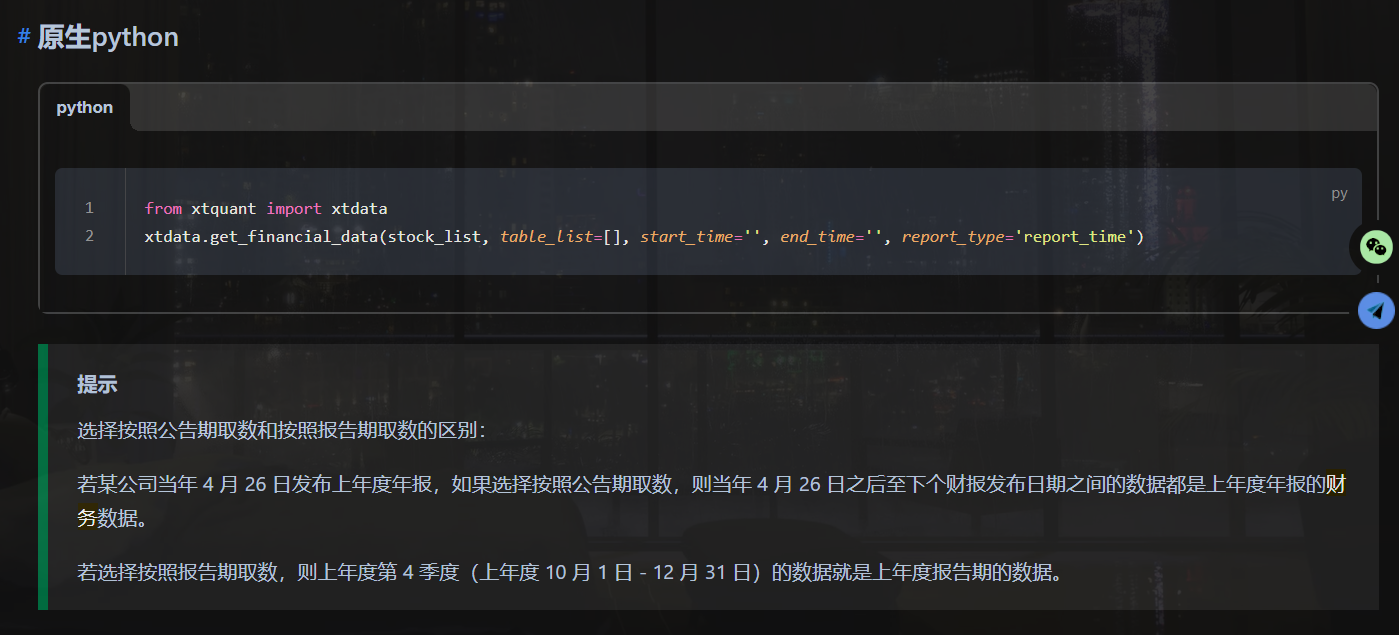

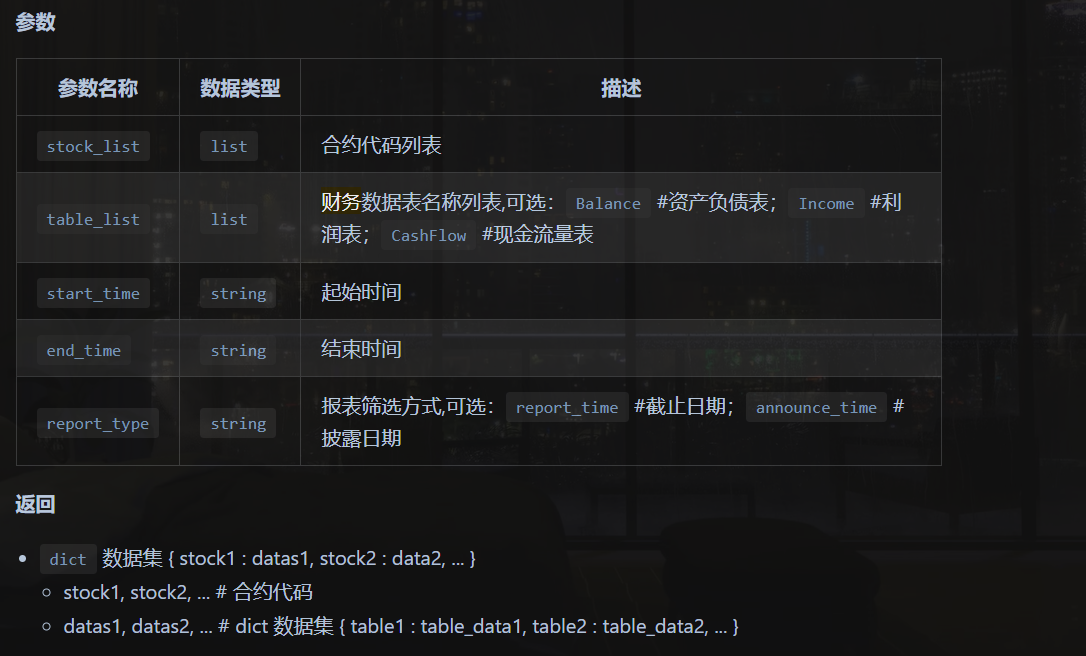

```python
from xtquant import xtdata
# 取数据前请确保已下载所需要的财务数据
xtdata.download_financial_data(["000001.SZ", "600519.SH", "430017.BJ"], 
                               table_list=["Balance", "Income"])
xtdata.get_financial_data(["000001.SZ", "600519.SH", "430017.BJ"],
                          ["Balance", "Income"])
```